[INFO] Files used: 15
[INFO] Train frames: 840  |  Test frames: 150
Train class counts:
 sit      168
walk     168
lying    168
stand    168
fall     168
Name: count, dtype: int64
Test  class counts:
 lying    30
walk     30
stand    30
fall     30
sit      30
Name: count, dtype: int64
[INFO] Dropped 6 near-constant features.

=== SVM (per-file 10-frame holdout) ===
Best params: {'svc__C': 5, 'svc__class_weight': None, 'svc__gamma': 0.01}
Accuracy: 0.6666666666666666
              precision    recall  f1-score   support

        fall       0.81      0.87      0.84        30
       lying       0.71      0.67      0.69        30
         sit       0.70      0.77      0.73        30
       stand       0.50      0.47      0.48        30
        walk       0.59      0.57      0.58        30

    accuracy                           0.67       150
   macro avg       0.66      0.67      0.66       150
weighted avg       0.66      0.67      0.66       150



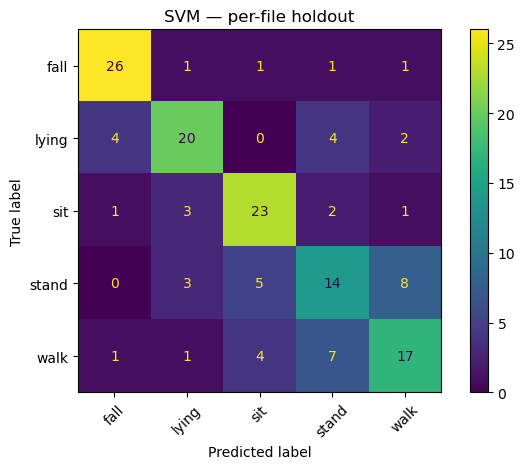

C:\Users\USER\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\USER\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\USER\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\USER\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^


=== KNN (per-file 10-frame holdout) ===
Best params: {'knn__n_neighbors': 9, 'knn__p': 2, 'knn__weights': 'distance'}
Accuracy: 0.6
              precision    recall  f1-score   support

        fall       0.76      0.87      0.81        30
       lying       0.74      0.47      0.57        30
         sit       0.56      0.60      0.58        30
       stand       0.44      0.40      0.42        30
        walk       0.53      0.67      0.59        30

    accuracy                           0.60       150
   macro avg       0.61      0.60      0.59       150
weighted avg       0.61      0.60      0.59       150



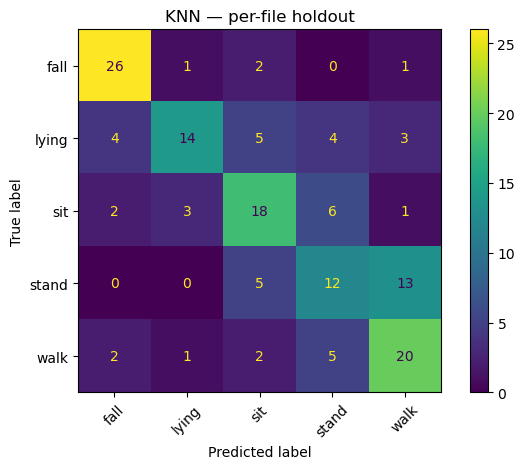

In [2]:
import os, glob, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.cluster import DBSCAN
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

DATA_DIR = r"C:\Users\USER\precomputed_pointclouds\magnitude"
RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

# Feature knobs
KEEP_TOP_PCT = 0.30            
DBSCAN_EPS = 0.12              
DBSCAN_MIN_SAMPLES = 8
CYL_Z_BINS = 6
CYL_R_BINS = 6
CONST_BIN_STD_EPS = 1e-8       

# Holdout strategy
HOLDOUT_FRAMES_PER_FILE = 10   


#function created in convertingCSVtoNPZ notebook
def _clean_mag_pc(pc):
    if pc is None:
        return np.zeros((0,4), np.float32)
    arr = np.asarray(pc)
    if arr.ndim == 1:
        arr = np.atleast_2d(arr)
    if arr.shape[1] == 3:
        arr = np.column_stack([arr, np.zeros((arr.shape[0],), dtype=arr.dtype)])
    if arr.ndim != 2 or arr.shape[1] != 4:
        return np.zeros((0,4), np.float32)
    arr = arr.astype(np.float32, copy=False)
    return arr[np.isfinite(arr).all(axis=1)]

#robust scaling of mags
def _robust_scale_magnitudes(m):
    med = np.median(m)
    q1, q3 = np.percentile(m, [25, 75])
    iqr = q3 - q1
    if iqr < 1e-6:
        s = np.std(m) + 1e-6
        return (m - med) / s
    return (m - med) / (iqr + 1e-6)

#aiding feature selection by choosing higher mag clusters as representive of a target
def _choose_cluster_by_sum_mag(xyz, mag):
    labels = DBSCAN(eps=DBSCAN_EPS, min_samples=DBSCAN_MIN_SAMPLES).fit_predict(xyz)
    if np.all(labels == -1):
        return np.ones(xyz.shape[0], dtype=bool)
    best_lbl, best_sum = None, -1.0
    for lbl in np.unique(labels):
        if lbl == -1:
            continue
        idx = (labels == lbl)
        s = mag[idx].sum()
        if s > best_sum:
            best_sum, best_lbl = s, lbl
    if best_lbl is None:
        return np.ones(xyz.shape[0], dtype=bool)
    return labels == best_lbl

#retrieving eigenvalue based features 
def _eigen_features(X):
    if X.shape[0] < 3:
        return np.zeros(5, dtype=float)
    C = np.cov(X.T)
    vals = np.sort(np.maximum(np.linalg.eigvalsh(C), 1e-12))[::-1]
    l1, l2, l3 = vals
    linearity  = (l1 - l2) / (l1 + 1e-12)#how much points align along single direction
    planarity  = (l2 - l3) / (l1 + 1e-12)#how flat distribution is
    scattering =  l3 / (l1 + 1e-12)#dispersion in 3D
    sphericity =  l3 / (l1 + l2 + l3 + 1e-12)#similarity to spherical
    anisotropy = (l1 - l3) / (l1 + 1e-12)#difference between strongest/weakest spread
    return np.array([linearity, planarity, scattering, sphericity, anisotropy], float)

#cylindrical occupancy histogram, projects points to z and radial dist r
def _cyl_hist(Xn):
    z = Xn[:,2]
    r = np.sqrt(Xn[:,0]**2 + Xn[:,1]**2)
    z_edges = np.linspace(0, 1, CYL_Z_BINS+1)
    r_edges = np.linspace(0, np.percentile(r, 95)+1e-6, CYL_R_BINS+1)
    H, _, _ = np.histogram2d(z, r, bins=[z_edges, r_edges])
    H = H / (H.sum() + 1e-9)
    return H.ravel()#normalized flattened histogram(sums to 1)

#extracting feature vector from single pointcloud/frame
def extract_features_from_frame(arr):
    if arr.size == 0:
        return None
    x,y,z,mag = arr.T
    if mag.size < 40:
        return None

    #magnitude scaling to avoid session biases
    m_norm = _robust_scale_magnitudes(mag)

    #thresholding
    k = int(max(1, np.floor((1.0 - KEEP_TOP_PCT) * m_norm.size)))
    thr = np.partition(m_norm, k)[k]
    keep = m_norm >= thr
    if keep.sum() < 30:
        return None
    xyz = arr[keep, :3]
    m_kept = m_norm[keep] 

    #cluster selection by max mag to isolate person
    mask = _choose_cluster_by_sum_mag(xyz, m_kept)
    xyz = xyz[mask, :]
    m_kept = m_kept[mask]
    if xyz.shape[0] < 30:
        return None

    #density (points per bbox volume)
    mins = xyz.min(axis=0); maxs = xyz.max(axis=0)
    ext = np.maximum(maxs - mins, 1e-6)
    bbox_vol = float(ext[0]*ext[1]*ext[2])
    density = float(xyz.shape[0]) / bbox_vol

    #normalising, centrering around centroid, scaling by z range
    centroid = xyz.mean(axis=0)
    Xc = xyz - centroid
    z_range = np.ptp(xyz[:,2])
    scale = z_range if z_range > 1e-6 else 1.0
    Xn = Xc / scale
    zn = (xyz[:,2] - xyz[:,2].min()) / (z_range + 1e-9)
    r = np.sqrt(Xn[:,0]**2 + Xn[:,1]**2)

    #geometry/magnitude descriptors
    z_q10, z_q50, z_q90 = np.quantile(zn, [0.10, 0.50, 0.90])
    r_mean, r_std = r.mean(), r.std()
    mg_mean, mg_std, mg_max = m_kept.mean(), m_kept.std(), m_kept.max()
    eig = _eigen_features(Xn)
    hist = _cyl_hist(Xn)

    #concatenating into final 1d feature vector
    feat = np.concatenate([
        np.array([mg_mean, mg_std, mg_max, z_range, density, z_q10, z_q50, z_q90, r_mean, r_std], float),
        eig,
        hist
    ])
    return feat

#assigning readable feature names 
def feature_names(sample_vec_len):
    base = [
        "mag_mean","mag_std","mag_max","z_range","density",
        "z_q10","z_q50","z_q90","r_mean","r_std",
        "eig_linearity","eig_planarity","eig_scattering","eig_sphericity","eig_anisotropy"
    ]
    hist = [f"occ_z{i}_r{j}" for i in range(CYL_Z_BINS) for j in range(CYL_R_BINS)]
    names = base + hist
    if len(names) != sample_vec_len:
        names = [f"f{i}" for i in range(sample_vec_len)]
    return names

#file loader, for ech .npz file, extract features, split into train and test, avoids leakage, ensures 1 frame per file goes to test
def load_per_file_holdout_anonymized(
    data_dir,
    holdout_per_file=HOLDOUT_FRAMES_PER_FILE,
    return_groups=False,                # set True for anonomized IDs
):
    rng = random.Random(RANDOM_STATE)

    #gather per file features
    per_file = [] 
    next_fid = 0

    for path in sorted(glob.glob(os.path.join(data_dir, "*.npz"))):
        d = np.load(path, allow_pickle=True)
        if "pcs" not in d.files or "label" not in d.files:
            continue
        label = str(d["label"])
        pcs = list(d["pcs"])#list of point cloud frames

        feats = []
        for pc in pcs:
            f = extract_features_from_frame(_clean_mag_pc(pc))
            if f is not None:
                feats.append(f)
        if not feats:
            continue

        #store file
        per_file.append({"fid": next_fid, "label": label, "feats": feats})
        next_fid += 1

    if not per_file:
        raise RuntimeError("No usable data after extraction. Check settings or data.")
    
    #for each file split frames to test train
    train_rows, test_rows = [], []
    for rec in per_file:
        feats = rec["feats"]#list of feature vectors
        lbl   = rec["label"]#labels
        fid   = rec["fid"]#id

        idx = list(range(len(feats)))
        rng.shuffle(idx)

        #assign files to train or test
        take = min(holdout_per_file, max(1, len(feats)//6))  #~1/6 to test, min 1
        te_idx = set(idx[:take])
        for i, f in enumerate(feats):
            row = (f, lbl, fid)
            if i in te_idx:
                test_rows.append(row)
            else:
                train_rows.append(row)

    if not train_rows or not test_rows:
        raise RuntimeError("Empty train/test after split; reduce holdout_per_file or check data.")

    #shuffling the rows to stop model learning due to file ordering and sequence
    rng.shuffle(train_rows)
    rng.shuffle(test_rows)

    #building numpy arrays for Ml pipeline
    Xtr = np.array([r[0] for r in train_rows], dtype=float)
    ytr = np.array([r[1] for r in train_rows])
    gtr = np.array([r[2] for r in train_rows], dtype=int)

    Xte = np.array([r[0] for r in test_rows], dtype=float)
    yte = np.array([r[1] for r in test_rows])
    gte = np.array([r[2] for r in test_rows], dtype=int)

    #printing some diagnostic info
    print(f"[INFO] Files used: {len(per_file)}")
    print(f"[INFO] Train frames: {len(Xtr)}  |  Test frames: {len(Xte)}")
    print("Train class counts:\n", pd.Series(ytr).value_counts())
    print("Test  class counts:\n", pd.Series(yte).value_counts())

    if return_groups:
        return Xtr, ytr, Xte, yte, gtr, gte
    return Xtr, ytr, Xte, yte


#pruning occupancy bins, dropping cols with little feature variability and of little use
def prune_constant_bins(Xtr, Xte):
    stds = Xtr.std(axis=0)
    keep = stds >= CONST_BIN_STD_EPS
    Xtr2 = Xtr[:, keep]
    Xte2 = Xte[:, keep]
    dropped = np.where(~keep)[0].tolist()
    if dropped:
        print(f"[INFO] Dropped {len(dropped)} near-constant features.")
    return Xtr2, Xte2, keep

#training and evaluation
def train_and_eval(Xtr, ytr, Xte, yte):
    #pruning irrelevant features
    Xtr2, Xte2, keep_mask = prune_constant_bins(Xtr, Xte)

    #SVM using gridsearchCV
    svm = Pipeline([("scaler", StandardScaler()),
                    ("svc", SVC(kernel="rbf", decision_function_shape="ovr"))])
    svm_grid = {"svc__C":[0.5,1,2,5,10],
                "svc__gamma":["scale",0.1,0.05,0.01],
                "svc__class_weight":[None,"balanced"]}
    gs_svm = GridSearchCV(svm, svm_grid, cv=3, scoring="f1_macro", n_jobs=-1)
    gs_svm.fit(Xtr2, ytr)
    yps = gs_svm.best_estimator_.predict(Xte2)
    print("\n=== SVM (per-file 10-frame holdout) ===")
    print("Best params:", gs_svm.best_params_)
    print("Accuracy:", accuracy_score(yte, yps))
    print(classification_report(yte, yps))
    cm = confusion_matrix(yte, yps, labels=np.unique(ytr))
    ConfusionMatrixDisplay(cm, display_labels=np.unique(ytr)).plot(xticks_rotation=45)
    plt.title("SVM — per-file holdout"); plt.tight_layout(); plt.show()

    #KNN using gridsearch
    knn = Pipeline([("scaler", StandardScaler()), ("knn", KNeighborsClassifier())])
    knn_grid = {"knn__n_neighbors":[3,5,7,9,11],
                "knn__weights":["uniform","distance"],
                "knn__p":[2]}
    gs_knn = GridSearchCV(knn, knn_grid, cv=3, scoring="f1_macro", n_jobs=-1)
    gs_knn.fit(Xtr2, ytr)
    ypk = gs_knn.best_estimator_.predict(Xte2)
    print("\n=== KNN (per-file 10-frame holdout) ===")
    print("Best params:", gs_knn.best_params_)
    print("Accuracy:", accuracy_score(yte, ypk))
    print(classification_report(yte, ypk))
    cm = confusion_matrix(yte, ypk, labels=np.unique(ytr))
    ConfusionMatrixDisplay(cm, display_labels=np.unique(ytr)).plot(xticks_rotation=45)
    plt.title("KNN — per-file holdout"); plt.tight_layout(); plt.show()

    return (yps, ypk, keep_mask)

#main
if __name__ == "__main__":
    #performing train test split
    X_train, y_train, X_test, y_test = load_per_file_holdout_anonymized(DATA_DIR, HOLDOUT_FRAMES_PER_FILE)

    #training and evaluation
    _ = train_and_eval(X_train, y_train, X_test, y_test)


In [5]:
#function to train svm and knn on shuffled labels, should be no relationship with randomized labels
#classifiers should perform approx random chance or 20% acc, higher suggests leakeage
def sanity_check_random_labels(X_tr, y_tr, X_te, y_te, repeats: int = 5):
    accs_svm, accs_knn = [], []
    for _ in range(repeats):
        y_tr_shuf = np.random.permutation(y_tr)

        svm = Pipeline([("scaler", StandardScaler()),
                        ("svc", SVC(kernel="rbf", decision_function_shape="ovr"))])
        gs_svm = GridSearchCV(
            svm,
            {"svc__C":[0.5,1,2,5,10], "svc__gamma":["scale",0.1,0.05,0.01], "svc__class_weight":[None,"balanced"]},
            cv=3, scoring="f1_macro", n_jobs=-1
        )
        gs_svm.fit(X_tr, y_tr_shuf)
        accs_svm.append(accuracy_score(y_te, gs_svm.best_estimator_.predict(X_te)))

        knn = Pipeline([("scaler", StandardScaler()),
                        ("knn", KNeighborsClassifier())])
        gs_knn = GridSearchCV(
            knn,
            {"knn__n_neighbors":[3,5,7,9], "knn__weights":["uniform","distance"], "knn__p":[2]},
            cv=3, scoring="f1_macro", n_jobs=-1
        )
        gs_knn.fit(X_tr, y_tr_shuf)
        accs_knn.append(accuracy_score(y_te, gs_knn.best_estimator_.predict(X_te)))

    print("\n=== Sanity check (train on SHUFFLED labels) ===")
    print(f"SVM accuracy (mean±std over {repeats}): {np.mean(accs_svm):.3f} ± {np.std(accs_svm):.3f}")
    print(f"KNN accuracy (mean±std over {repeats}): {np.mean(accs_knn):.3f} ± {np.std(accs_knn):.3f}")
    print("(These should be ~0.20 for 5 balanced classes.)")


sanity_check_random_labels(X_train, y_train, X_test, y_test, repeats=5)



=== Sanity check (train on SHUFFLED labels) ===
SVM accuracy (mean±std over 5): 0.184 ± 0.032
KNN accuracy (mean±std over 5): 0.197 ± 0.022
(These should be ~0.20 for 5 balanced classes.)


[INFO] Raw files: 15 | Raw frames: 990

[INFO] KEEP_TOP_PCT = 30%
[INFO] Common usable frames: 990 | X_mag dim: 51 | X_nomag dim: 48
Class counts (common):
 fall     198
sit      198
lying    198
stand    198
walk     198
Name: count, dtype: int64

----- Training/Eval: stratified • NO MAG FEATURES • keep=30% -----
[INFO] Dropped 4 near-constant features.

=== SVM — stratified • NO MAG FEATURES • keep=30% ===
Best params: {'svc__C': 2, 'svc__class_weight': 'balanced', 'svc__gamma': 0.05}
Accuracy: 0.6111111111111112
              precision    recall  f1-score   support

        fall       0.58      0.55      0.56        40
       lying       0.66      0.74      0.70        39
         sit       0.56      0.68      0.61        40
       stand       0.74      0.42      0.54        40
        walk       0.58      0.67      0.62        39

    accuracy                           0.61       198
   macro avg       0.62      0.61      0.61       198
weighted avg       0.62      0.61      0.61  

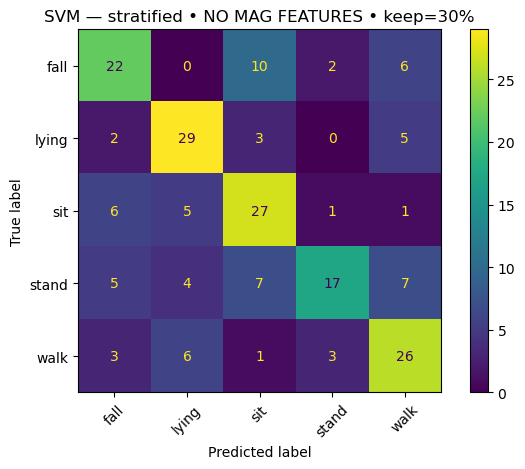

C:\Users\USER\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== LogReg — stratified • NO MAG FEATURES • keep=30% ===
Best params: {'lr__C': 10, 'lr__class_weight': None, 'lr__penalty': 'l2'}
Accuracy: 0.5757575757575758
              precision    recall  f1-score   support

        fall       0.58      0.62      0.60        40
       lying       0.59      0.62      0.60        39
         sit       0.63      0.60      0.62        40
       stand       0.59      0.47      0.53        40
        walk       0.50      0.56      0.53        39

    accuracy                           0.58       198
   macro avg       0.58      0.58      0.58       198
weighted avg       0.58      0.58      0.58       198



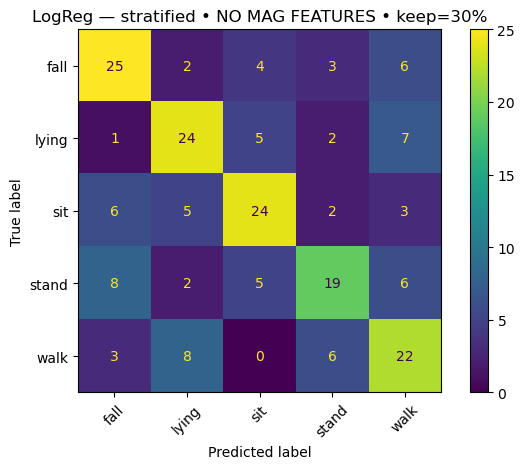


=== RF — stratified • NO MAG FEATURES • keep=30% ===
Best params: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
Accuracy: 0.6262626262626263
              precision    recall  f1-score   support

        fall       0.62      0.62      0.62        40
       lying       0.68      0.69      0.68        39
         sit       0.68      0.65      0.67        40
       stand       0.58      0.47      0.52        40
        walk       0.57      0.69      0.63        39

    accuracy                           0.63       198
   macro avg       0.63      0.63      0.62       198
weighted avg       0.63      0.63      0.62       198



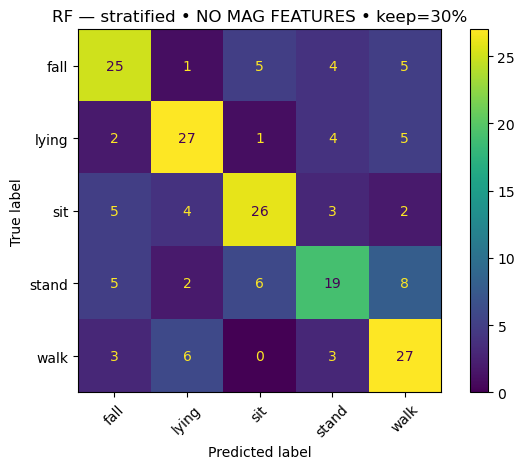


=== kNN — stratified • NO MAG FEATURES • keep=30% ===
Best params: {'knn__n_neighbors': 5, 'knn__p': 2, 'knn__weights': 'distance'}
Accuracy: 0.5202020202020202
              precision    recall  f1-score   support

        fall       0.47      0.68      0.56        40
       lying       0.55      0.46      0.50        39
         sit       0.56      0.57      0.57        40
       stand       0.64      0.35      0.45        40
        walk       0.47      0.54      0.50        39

    accuracy                           0.52       198
   macro avg       0.54      0.52      0.52       198
weighted avg       0.54      0.52      0.52       198



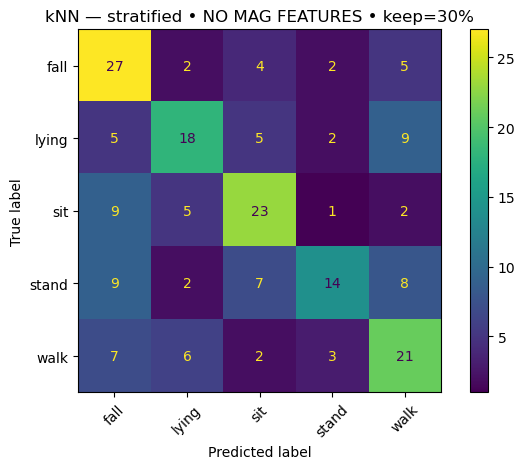


----- Training/Eval: stratified • WITH MAG FEATURES • keep=30% -----
[INFO] Dropped 4 near-constant features.

=== SVM — stratified • WITH MAG FEATURES • keep=30% ===
Best params: {'svc__C': 2, 'svc__class_weight': None, 'svc__gamma': 0.05}
Accuracy: 0.696969696969697
              precision    recall  f1-score   support

        fall       0.74      0.70      0.72        40
       lying       0.73      0.85      0.79        39
         sit       0.67      0.80      0.73        40
       stand       0.70      0.47      0.57        40
        walk       0.65      0.67      0.66        39

    accuracy                           0.70       198
   macro avg       0.70      0.70      0.69       198
weighted avg       0.70      0.70      0.69       198



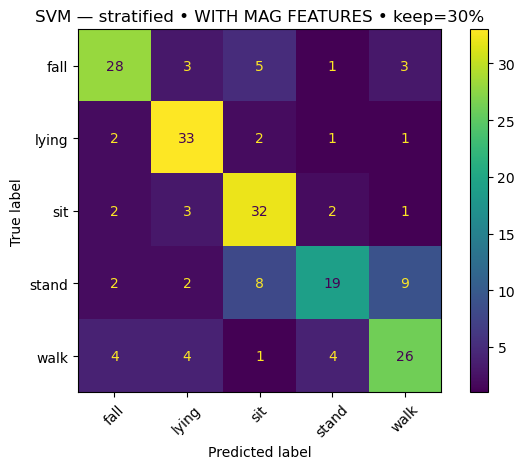

C:\Users\USER\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== LogReg — stratified • WITH MAG FEATURES • keep=30% ===
Best params: {'lr__C': 1, 'lr__class_weight': None, 'lr__penalty': 'l2'}
Accuracy: 0.6464646464646465
              precision    recall  f1-score   support

        fall       0.74      0.72      0.73        40
       lying       0.62      0.64      0.63        39
         sit       0.70      0.75      0.72        40
       stand       0.58      0.53      0.55        40
        walk       0.57      0.59      0.58        39

    accuracy                           0.65       198
   macro avg       0.64      0.65      0.64       198
weighted avg       0.65      0.65      0.65       198



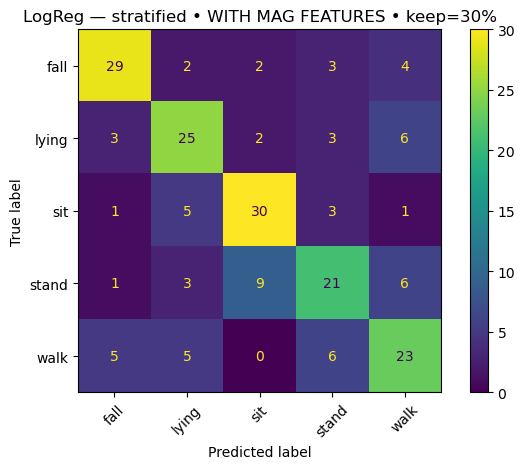


=== RF — stratified • WITH MAG FEATURES • keep=30% ===
Best params: {'class_weight': None, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 400}
Accuracy: 0.7474747474747475
              precision    recall  f1-score   support

        fall       0.78      0.80      0.79        40
       lying       0.84      0.82      0.83        39
         sit       0.74      0.85      0.79        40
       stand       0.68      0.53      0.59        40
        walk       0.69      0.74      0.72        39

    accuracy                           0.75       198
   macro avg       0.75      0.75      0.74       198
weighted avg       0.75      0.75      0.74       198



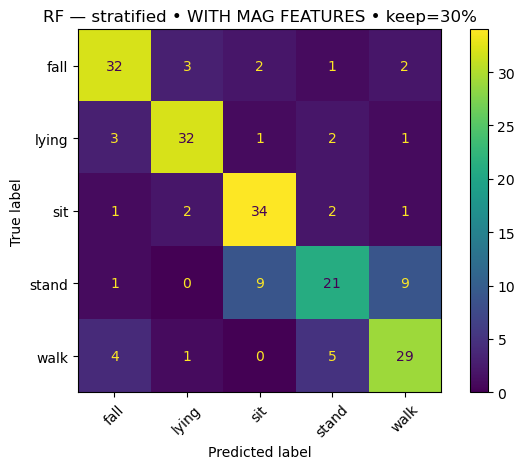


=== kNN — stratified • WITH MAG FEATURES • keep=30% ===
Best params: {'knn__n_neighbors': 7, 'knn__p': 1, 'knn__weights': 'distance'}
Accuracy: 0.6818181818181818
              precision    recall  f1-score   support

        fall       0.64      0.88      0.74        40
       lying       0.91      0.51      0.66        39
         sit       0.60      0.75      0.67        40
       stand       0.78      0.53      0.63        40
        walk       0.66      0.74      0.70        39

    accuracy                           0.68       198
   macro avg       0.72      0.68      0.68       198
weighted avg       0.72      0.68      0.68       198



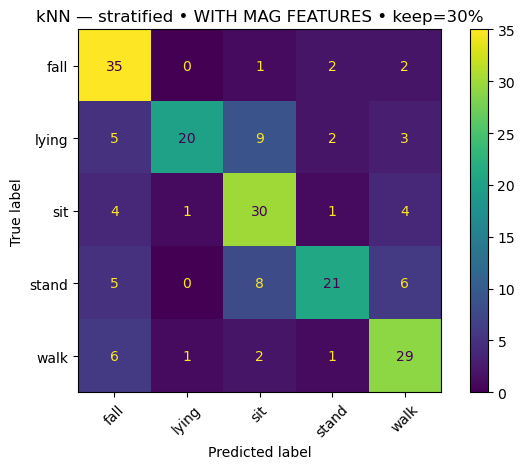


[INFO] KEEP_TOP_PCT = 60%
[INFO] Common usable frames: 990 | X_mag dim: 51 | X_nomag dim: 48
Class counts (common):
 fall     198
sit      198
lying    198
stand    198
walk     198
Name: count, dtype: int64

----- Training/Eval: stratified • NO MAG FEATURES • keep=60% -----
[INFO] Dropped 12 near-constant features.

=== SVM — stratified • NO MAG FEATURES • keep=60% ===
Best params: {'svc__C': 5, 'svc__class_weight': None, 'svc__gamma': 'scale'}
Accuracy: 0.4797979797979798
              precision    recall  f1-score   support

        fall       0.49      0.60      0.54        40
       lying       0.40      0.44      0.42        39
         sit       0.50      0.33      0.39        40
       stand       0.37      0.33      0.35        40
        walk       0.61      0.72      0.66        39

    accuracy                           0.48       198
   macro avg       0.47      0.48      0.47       198
weighted avg       0.47      0.48      0.47       198



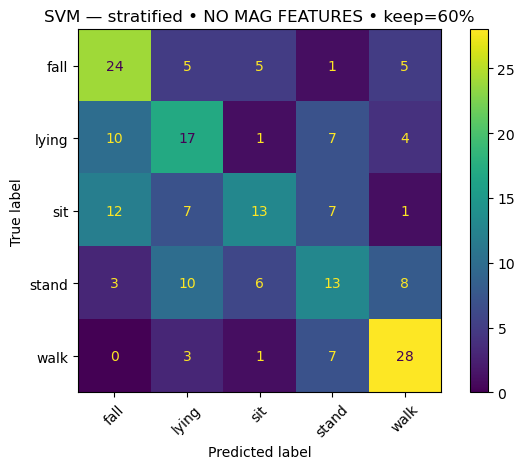

C:\Users\USER\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== LogReg — stratified • NO MAG FEATURES • keep=60% ===
Best params: {'lr__C': 1, 'lr__class_weight': 'balanced', 'lr__penalty': 'l2'}
Accuracy: 0.4444444444444444
              precision    recall  f1-score   support

        fall       0.41      0.47      0.44        40
       lying       0.41      0.44      0.42        39
         sit       0.35      0.33      0.34        40
       stand       0.41      0.28      0.33        40
        walk       0.60      0.72      0.65        39

    accuracy                           0.44       198
   macro avg       0.44      0.45      0.44       198
weighted avg       0.44      0.44      0.44       198



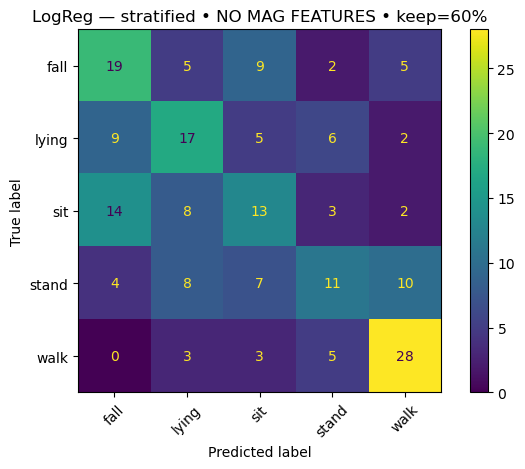


=== RF — stratified • NO MAG FEATURES • keep=60% ===
Best params: {'class_weight': None, 'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}
Accuracy: 0.5050505050505051
              precision    recall  f1-score   support

        fall       0.50      0.53      0.51        40
       lying       0.51      0.51      0.51        39
         sit       0.63      0.42      0.51        40
       stand       0.40      0.40      0.40        40
        walk       0.52      0.67      0.58        39

    accuracy                           0.51       198
   macro avg       0.51      0.51      0.50       198
weighted avg       0.51      0.51      0.50       198



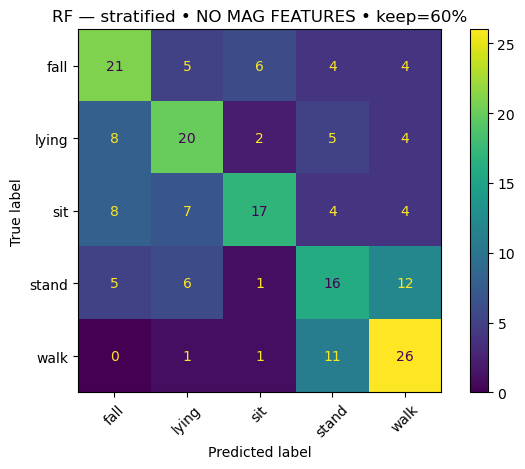


=== kNN — stratified • NO MAG FEATURES • keep=60% ===
Best params: {'knn__n_neighbors': 5, 'knn__p': 1, 'knn__weights': 'distance'}
Accuracy: 0.43434343434343436
              precision    recall  f1-score   support

        fall       0.39      0.62      0.48        40
       lying       0.39      0.31      0.34        39
         sit       0.48      0.30      0.37        40
       stand       0.44      0.28      0.34        40
        walk       0.49      0.67      0.57        39

    accuracy                           0.43       198
   macro avg       0.44      0.43      0.42       198
weighted avg       0.44      0.43      0.42       198



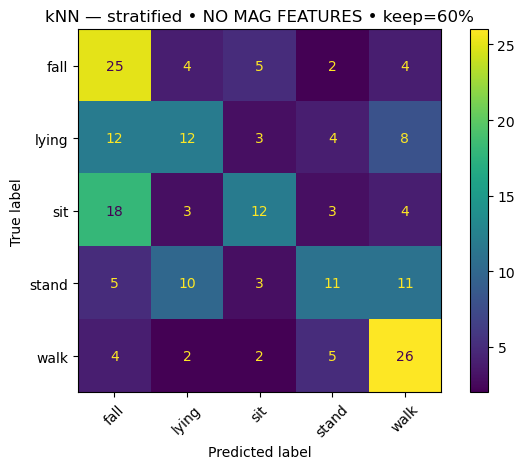


----- Training/Eval: stratified • WITH MAG FEATURES • keep=60% -----
[INFO] Dropped 12 near-constant features.

=== SVM — stratified • WITH MAG FEATURES • keep=60% ===
Best params: {'svc__C': 5, 'svc__class_weight': None, 'svc__gamma': 'scale'}
Accuracy: 0.5656565656565656
              precision    recall  f1-score   support

        fall       0.71      0.68      0.69        40
       lying       0.50      0.49      0.49        39
         sit       0.59      0.57      0.58        40
       stand       0.38      0.35      0.36        40
        walk       0.63      0.74      0.68        39

    accuracy                           0.57       198
   macro avg       0.56      0.57      0.56       198
weighted avg       0.56      0.57      0.56       198



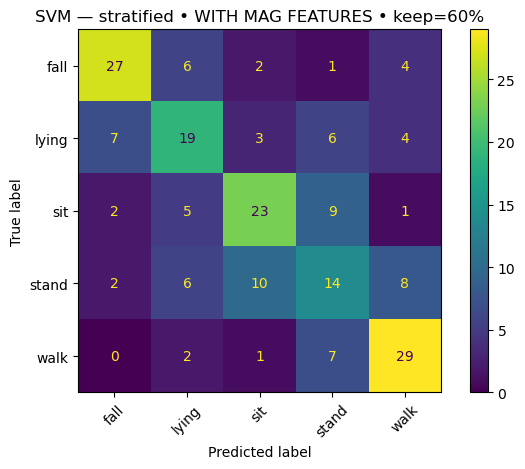

C:\Users\USER\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== LogReg — stratified • WITH MAG FEATURES • keep=60% ===
Best params: {'lr__C': 1, 'lr__class_weight': None, 'lr__penalty': 'l2'}
Accuracy: 0.51010101010101
              precision    recall  f1-score   support

        fall       0.55      0.60      0.57        40
       lying       0.47      0.46      0.47        39
         sit       0.50      0.47      0.49        40
       stand       0.43      0.30      0.35        40
        walk       0.56      0.72      0.63        39

    accuracy                           0.51       198
   macro avg       0.50      0.51      0.50       198
weighted avg       0.50      0.51      0.50       198



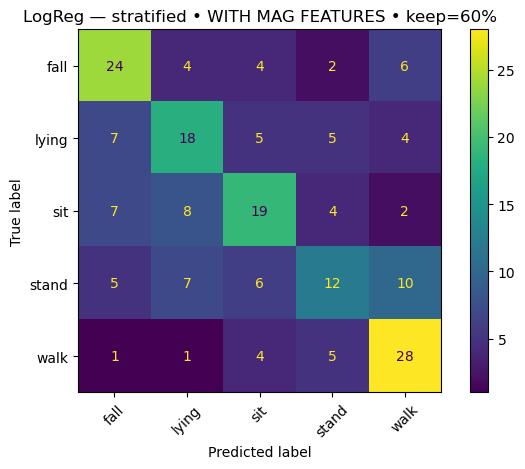


=== RF — stratified • WITH MAG FEATURES • keep=60% ===
Best params: {'class_weight': None, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 400}
Accuracy: 0.6414141414141414
              precision    recall  f1-score   support

        fall       0.81      0.75      0.78        40
       lying       0.75      0.62      0.68        39
         sit       0.56      0.72      0.63        40
       stand       0.62      0.40      0.48        40
        walk       0.55      0.72      0.62        39

    accuracy                           0.64       198
   macro avg       0.66      0.64      0.64       198
weighted avg       0.66      0.64      0.64       198



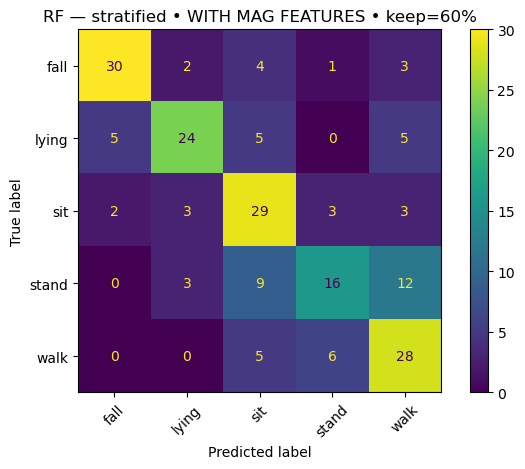


=== kNN — stratified • WITH MAG FEATURES • keep=60% ===
Best params: {'knn__n_neighbors': 9, 'knn__p': 1, 'knn__weights': 'distance'}
Accuracy: 0.5202020202020202
              precision    recall  f1-score   support

        fall       0.58      0.75      0.65        40
       lying       0.46      0.33      0.39        39
         sit       0.59      0.50      0.54        40
       stand       0.50      0.30      0.38        40
        walk       0.47      0.72      0.57        39

    accuracy                           0.52       198
   macro avg       0.52      0.52      0.50       198
weighted avg       0.52      0.52      0.50       198



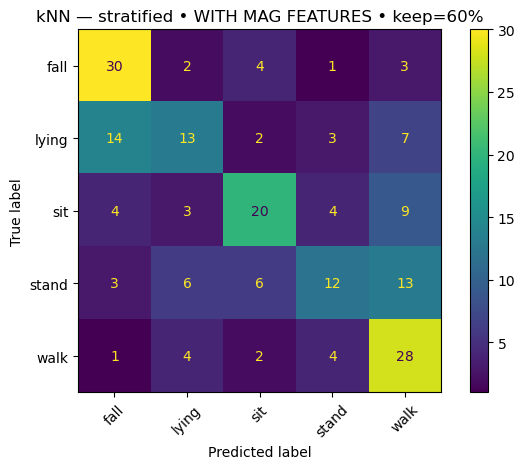


[INFO] KEEP_TOP_PCT = 80%
[INFO] Common usable frames: 990 | X_mag dim: 51 | X_nomag dim: 48
Class counts (common):
 fall     198
sit      198
lying    198
stand    198
walk     198
Name: count, dtype: int64

----- Training/Eval: stratified • NO MAG FEATURES • keep=80% -----
[INFO] Dropped 11 near-constant features.

=== SVM — stratified • NO MAG FEATURES • keep=80% ===
Best params: {'svc__C': 5, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale'}
Accuracy: 0.47474747474747475
              precision    recall  f1-score   support

        fall       0.51      0.68      0.58        40
       lying       0.48      0.56      0.52        39
         sit       0.29      0.20      0.24        40
       stand       0.48      0.30      0.37        40
        walk       0.54      0.64      0.59        39

    accuracy                           0.47       198
   macro avg       0.46      0.48      0.46       198
weighted avg       0.46      0.47      0.46       198



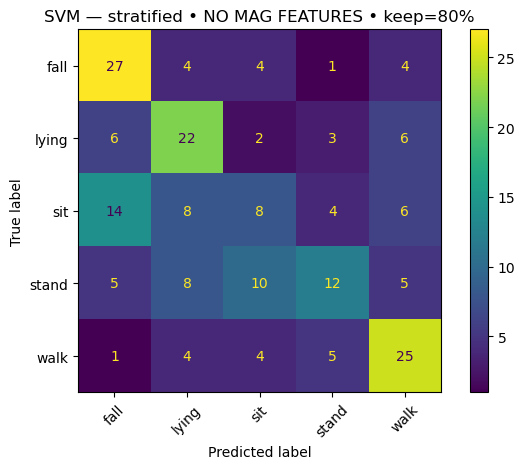

C:\Users\USER\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== LogReg — stratified • NO MAG FEATURES • keep=80% ===
Best params: {'lr__C': 1, 'lr__class_weight': 'balanced', 'lr__penalty': 'l2'}
Accuracy: 0.4393939393939394
              precision    recall  f1-score   support

        fall       0.53      0.57      0.55        40
       lying       0.43      0.51      0.47        39
         sit       0.31      0.30      0.30        40
       stand       0.35      0.30      0.32        40
        walk       0.57      0.51      0.54        39

    accuracy                           0.44       198
   macro avg       0.44      0.44      0.44       198
weighted avg       0.44      0.44      0.44       198



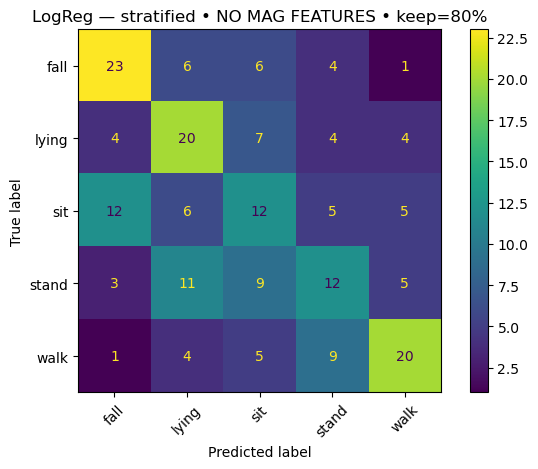


=== RF — stratified • NO MAG FEATURES • keep=80% ===
Best params: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 400}
Accuracy: 0.5151515151515151
              precision    recall  f1-score   support

        fall       0.58      0.70      0.64        40
       lying       0.62      0.51      0.56        39
         sit       0.50      0.42      0.46        40
       stand       0.35      0.38      0.36        40
        walk       0.54      0.56      0.55        39

    accuracy                           0.52       198
   macro avg       0.52      0.52      0.51       198
weighted avg       0.52      0.52      0.51       198



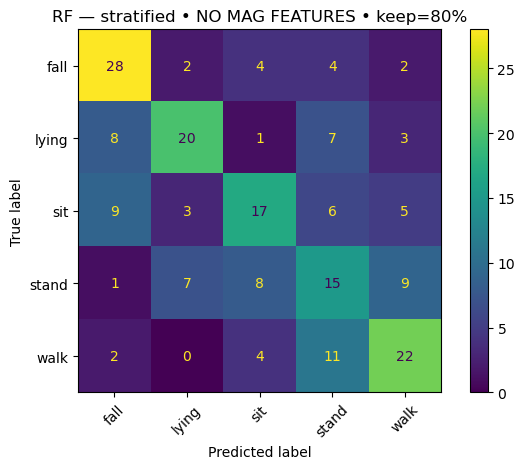


=== kNN — stratified • NO MAG FEATURES • keep=80% ===
Best params: {'knn__n_neighbors': 5, 'knn__p': 1, 'knn__weights': 'distance'}
Accuracy: 0.4292929292929293
              precision    recall  f1-score   support

        fall       0.40      0.70      0.51        40
       lying       0.46      0.31      0.37        39
         sit       0.43      0.15      0.22        40
       stand       0.53      0.42      0.47        40
        walk       0.39      0.56      0.46        39

    accuracy                           0.43       198
   macro avg       0.44      0.43      0.41       198
weighted avg       0.44      0.43      0.41       198



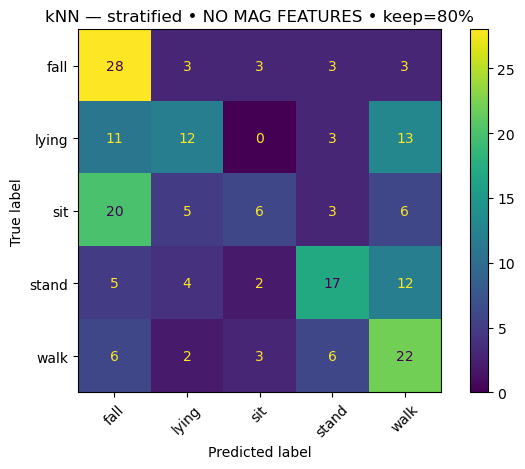


----- Training/Eval: stratified • WITH MAG FEATURES • keep=80% -----
[INFO] Dropped 11 near-constant features.

=== SVM — stratified • WITH MAG FEATURES • keep=80% ===
Best params: {'svc__C': 2, 'svc__class_weight': 'balanced', 'svc__gamma': 'scale'}
Accuracy: 0.6212121212121212
              precision    recall  f1-score   support

        fall       0.74      0.72      0.73        40
       lying       0.64      0.54      0.58        39
         sit       0.60      0.72      0.66        40
       stand       0.53      0.42      0.47        40
        walk       0.59      0.69      0.64        39

    accuracy                           0.62       198
   macro avg       0.62      0.62      0.62       198
weighted avg       0.62      0.62      0.62       198



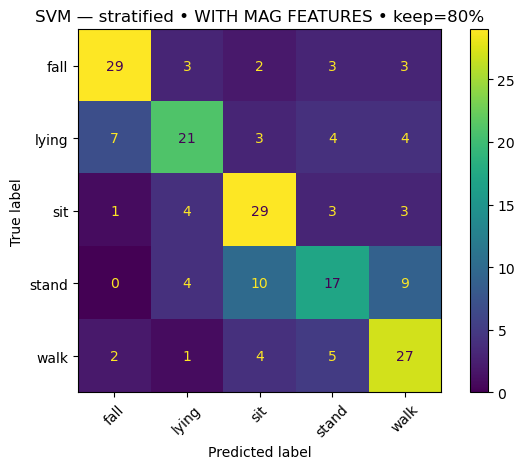

C:\Users\USER\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== LogReg — stratified • WITH MAG FEATURES • keep=80% ===
Best params: {'lr__C': 1, 'lr__class_weight': None, 'lr__penalty': 'l2'}
Accuracy: 0.5404040404040404
              precision    recall  f1-score   support

        fall       0.82      0.70      0.76        40
       lying       0.40      0.44      0.41        39
         sit       0.53      0.65      0.58        40
       stand       0.39      0.35      0.37        40
        walk       0.61      0.56      0.59        39

    accuracy                           0.54       198
   macro avg       0.55      0.54      0.54       198
weighted avg       0.55      0.54      0.54       198



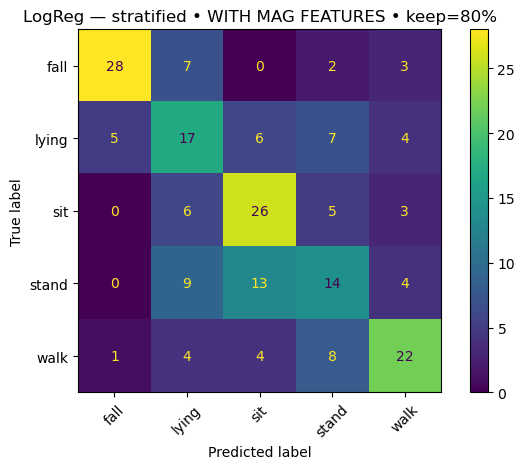


=== RF — stratified • WITH MAG FEATURES • keep=80% ===
Best params: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
Accuracy: 0.6262626262626263
              precision    recall  f1-score   support

        fall       0.76      0.72      0.74        40
       lying       0.84      0.54      0.66        39
         sit       0.54      0.82      0.65        40
       stand       0.47      0.38      0.42        40
        walk       0.62      0.67      0.64        39

    accuracy                           0.63       198
   macro avg       0.65      0.63      0.62       198
weighted avg       0.65      0.63      0.62       198



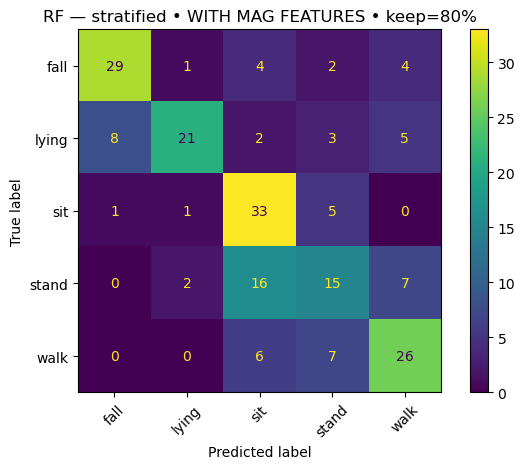


=== kNN — stratified • WITH MAG FEATURES • keep=80% ===
Best params: {'knn__n_neighbors': 9, 'knn__p': 1, 'knn__weights': 'uniform'}
Accuracy: 0.5
              precision    recall  f1-score   support

        fall       0.55      0.78      0.65        40
       lying       0.62      0.33      0.43        39
         sit       0.48      0.33      0.39        40
       stand       0.43      0.45      0.44        40
        walk       0.46      0.62      0.53        39

    accuracy                           0.50       198
   macro avg       0.51      0.50      0.49       198
weighted avg       0.51      0.50      0.49       198



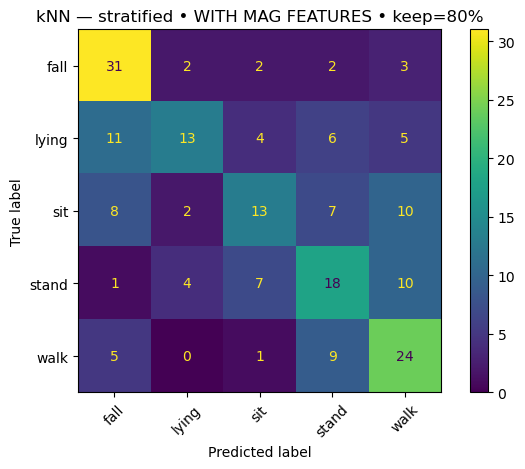


[INFO] KEEP_TOP_PCT = 100%
[INFO] Common usable frames: 990 | X_mag dim: 51 | X_nomag dim: 48
Class counts (common):
 fall     198
sit      198
lying    198
stand    198
walk     198
Name: count, dtype: int64

----- Training/Eval: stratified • NO MAG FEATURES • keep=100% -----
[INFO] Dropped 10 near-constant features.

=== SVM — stratified • NO MAG FEATURES • keep=100% ===
Best params: {'svc__C': 5, 'svc__class_weight': None, 'svc__gamma': 'scale'}
Accuracy: 0.5303030303030303
              precision    recall  f1-score   support

        fall       0.59      0.72      0.65        40
       lying       0.43      0.38      0.41        39
         sit       0.41      0.45      0.43        40
       stand       0.59      0.47      0.53        40
        walk       0.63      0.62      0.62        39

    accuracy                           0.53       198
   macro avg       0.53      0.53      0.53       198
weighted avg       0.53      0.53      0.53       198



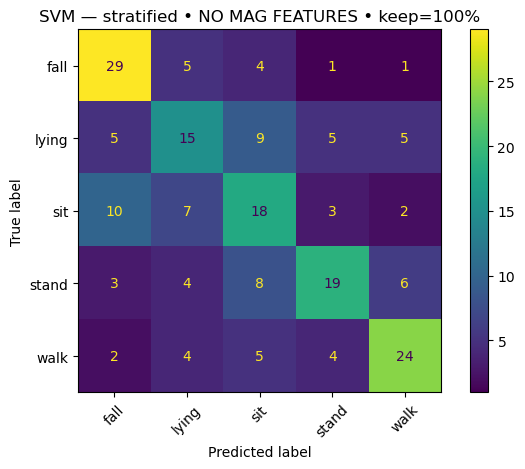

C:\Users\USER\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== LogReg — stratified • NO MAG FEATURES • keep=100% ===
Best params: {'lr__C': 5, 'lr__class_weight': None, 'lr__penalty': 'l2'}
Accuracy: 0.4393939393939394
              precision    recall  f1-score   support

        fall       0.49      0.60      0.54        40
       lying       0.40      0.36      0.38        39
         sit       0.41      0.35      0.38        40
       stand       0.42      0.38      0.39        40
        walk       0.45      0.51      0.48        39

    accuracy                           0.44       198
   macro avg       0.43      0.44      0.43       198
weighted avg       0.43      0.44      0.43       198



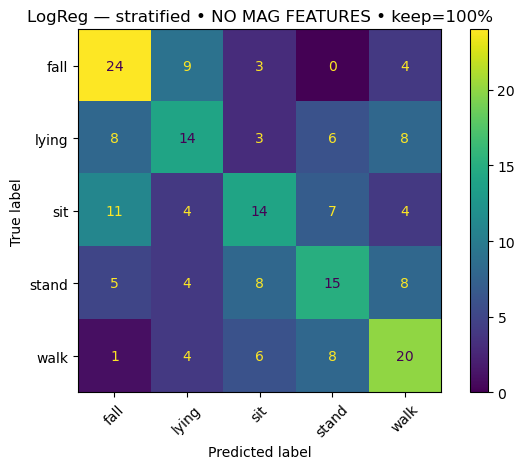


=== RF — stratified • NO MAG FEATURES • keep=100% ===
Best params: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400}
Accuracy: 0.45454545454545453
              precision    recall  f1-score   support

        fall       0.53      0.62      0.57        40
       lying       0.41      0.46      0.43        39
         sit       0.40      0.30      0.34        40
       stand       0.41      0.40      0.41        40
        walk       0.50      0.49      0.49        39

    accuracy                           0.45       198
   macro avg       0.45      0.45      0.45       198
weighted avg       0.45      0.45      0.45       198



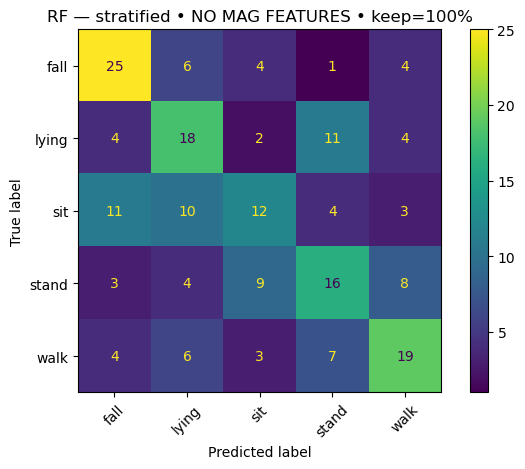


=== kNN — stratified • NO MAG FEATURES • keep=100% ===
Best params: {'knn__n_neighbors': 3, 'knn__p': 2, 'knn__weights': 'distance'}
Accuracy: 0.45454545454545453
              precision    recall  f1-score   support

        fall       0.48      0.65      0.55        40
       lying       0.41      0.31      0.35        39
         sit       0.39      0.17      0.24        40
       stand       0.50      0.45      0.47        40
        walk       0.44      0.69      0.54        39

    accuracy                           0.45       198
   macro avg       0.45      0.45      0.43       198
weighted avg       0.45      0.45      0.43       198



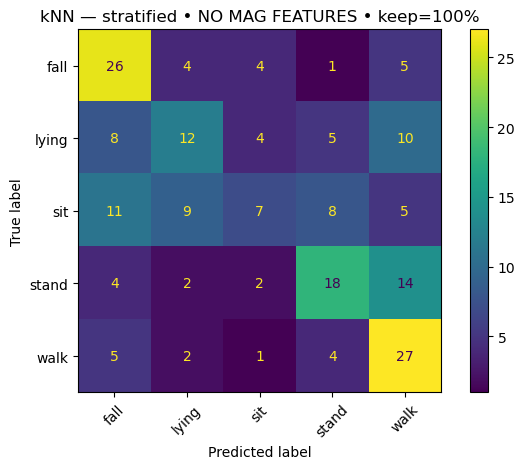


----- Training/Eval: stratified • WITH MAG FEATURES • keep=100% -----
[INFO] Dropped 10 near-constant features.

=== SVM — stratified • WITH MAG FEATURES • keep=100% ===
Best params: {'svc__C': 2, 'svc__class_weight': None, 'svc__gamma': 'scale'}
Accuracy: 0.5858585858585859
              precision    recall  f1-score   support

        fall       0.74      0.78      0.76        40
       lying       0.64      0.46      0.54        39
         sit       0.50      0.60      0.55        40
       stand       0.51      0.45      0.48        40
        walk       0.56      0.64      0.60        39

    accuracy                           0.59       198
   macro avg       0.59      0.59      0.58       198
weighted avg       0.59      0.59      0.58       198



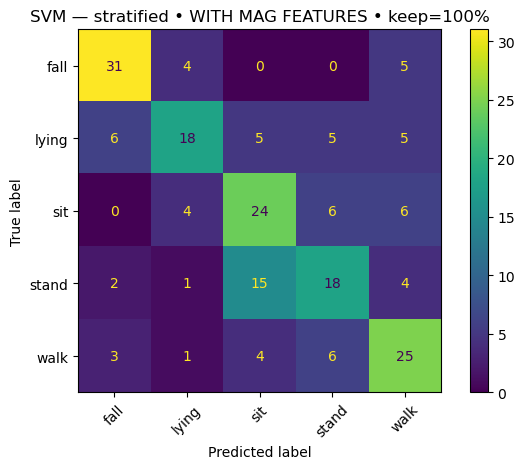

C:\Users\USER\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== LogReg — stratified • WITH MAG FEATURES • keep=100% ===
Best params: {'lr__C': 5, 'lr__class_weight': None, 'lr__penalty': 'l2'}
Accuracy: 0.494949494949495
              precision    recall  f1-score   support

        fall       0.61      0.57      0.59        40
       lying       0.38      0.38      0.38        39
         sit       0.48      0.55      0.51        40
       stand       0.52      0.38      0.43        40
        walk       0.50      0.59      0.54        39

    accuracy                           0.49       198
   macro avg       0.50      0.49      0.49       198
weighted avg       0.50      0.49      0.49       198



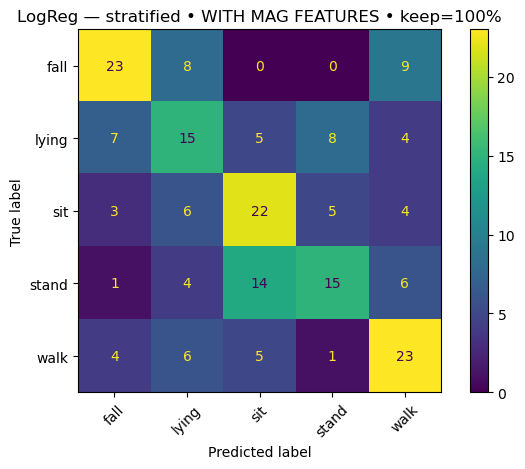


=== RF — stratified • WITH MAG FEATURES • keep=100% ===
Best params: {'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}
Accuracy: 0.5858585858585859
              precision    recall  f1-score   support

        fall       0.74      0.72      0.73        40
       lying       0.67      0.46      0.55        39
         sit       0.49      0.70      0.58        40
       stand       0.46      0.42      0.44        40
        walk       0.63      0.62      0.62        39

    accuracy                           0.59       198
   macro avg       0.60      0.59      0.58       198
weighted avg       0.60      0.59      0.58       198



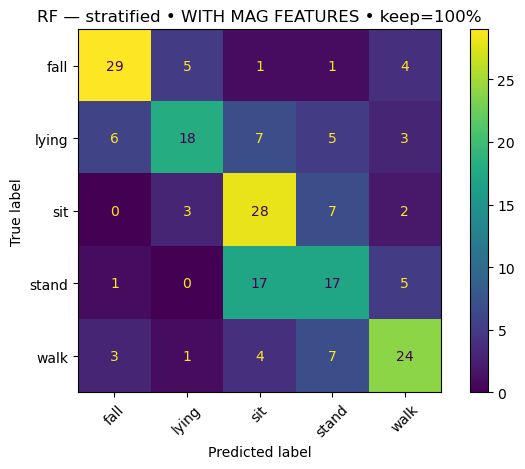


=== kNN — stratified • WITH MAG FEATURES • keep=100% ===
Best params: {'knn__n_neighbors': 9, 'knn__p': 1, 'knn__weights': 'distance'}
Accuracy: 0.5454545454545454
              precision    recall  f1-score   support

        fall       0.62      0.85      0.72        40
       lying       0.80      0.31      0.44        39
         sit       0.56      0.35      0.43        40
       stand       0.52      0.55      0.54        40
        walk       0.43      0.67      0.52        39

    accuracy                           0.55       198
   macro avg       0.59      0.54      0.53       198
weighted avg       0.59      0.55      0.53       198



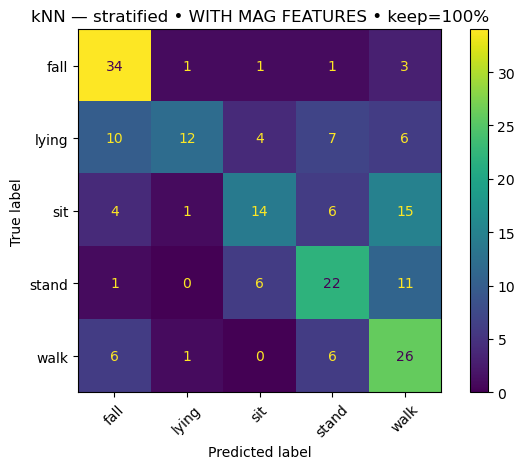


=== Summary across keep_top_pct thresholds ===
 keep_top_pct  variant  SVM acc  SVM macroF1   LR acc  LR macroF1   RF acc  RF macroF1  kNN acc  kNN macroF1
           30   NO MAG 0.611111     0.607053 0.575758    0.575139 0.626263    0.624733 0.520202     0.515243
           30 WITH MAG 0.696970     0.691266 0.646465    0.644978 0.747475    0.743918 0.681818     0.676981
           60   NO MAG 0.479798     0.471702 0.444444    0.436809 0.505051    0.503350 0.434343     0.419307
           60 WITH MAG 0.565657     0.562816 0.510101    0.501659 0.641414    0.638557 0.520202     0.504286
           80   NO MAG 0.474747     0.458210 0.439394    0.437599 0.515152    0.514130 0.429293     0.407185
           80 WITH MAG 0.621212     0.616824 0.540404    0.542150 0.626263    0.622389 0.500000     0.486745
          100   NO MAG 0.530303     0.527363 0.439394    0.434549 0.454545    0.449975 0.454545     0.432239
          100 WITH MAG 0.585859     0.582821 0.494949    0.492389 0.585859    0.

In [8]:
import os, glob, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier


#
#----------Training on same data as testing-----------------
#

#config
DATA_DIR = r"C:\Users\USER\precomputed_pointclouds\magnitude"
RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

SPLIT_MODE = "stratified"     
TEST_SIZE = 0.20               
HOLDOUT_FRAMES_PER_FILE = 10  

#DBSCAN clustering config
DBSCAN_EPS = 0.12
DBSCAN_MIN_SAMPLES = 8
CLUSTER_BY_MAG_FOR_BOTH = False

#Geometry features
CYL_Z_BINS = 6
CYL_R_BINS = 6
CONST_BIN_STD_EPS = 1e-8  

#noise intensity variation
KEEP_TOP_PCTS = [0.30, 0.60, 0.80, 1.00]   # 30%, 60%, 80%, 100%

#Plotting
PLOT_CM = True

#reusing previous functions
def _clean_mag_pc(pc):
    if pc is None:
        return np.zeros((0,4), np.float32)
    arr = np.asarray(pc)
    if arr.ndim == 1:
        arr = np.atleast_2d(arr)
    if arr.shape[1] == 3:
        arr = np.column_stack([arr, np.zeros((arr.shape[0],), dtype=arr.dtype)])
    if arr.ndim != 2 or arr.shape[1] != 4:
        return np.zeros((0,4), np.float32)
    arr = arr.astype(np.float32, copy=False)
    return arr[np.isfinite(arr).all(axis=1)]

def _robust_scale_magnitudes(m):
    med = np.median(m)
    q1, q3 = np.percentile(m, [25, 75])
    iqr = q3 - q1
    if iqr < 1e-6:
        s = np.std(m) + 1e-6
        return (m - med) / s
    return (m - med) / (iqr + 1e-6)

def _choose_cluster(xyz, mag_norm, by_mag=False):
    from sklearn.cluster import DBSCAN as _DB
    labels = _DB(eps=DBSCAN_EPS, min_samples=DBSCAN_MIN_SAMPLES).fit_predict(xyz)
    if np.all(labels == -1):
        return np.ones(xyz.shape[0], dtype=bool)
    best_lbl, best_score = None, -1.0
    for lbl in np.unique(labels):
        if lbl == -1:
            continue
        idx = (labels == lbl)
        score = mag_norm[idx].sum() if by_mag else idx.sum()
        if score > best_score:
            best_score, best_lbl = score, lbl
    if best_lbl is None:
        return np.ones(xyz.shape[0], dtype=bool)
    return labels == best_lbl

def _eigen_features(X):
    if X.shape[0] < 3:
        return np.zeros(5, dtype=float)
    C = np.cov(X.T)
    vals = np.sort(np.maximum(np.linalg.eigvalsh(C), 1e-12))[::-1]
    l1, l2, l3 = vals
    linearity  = (l1 - l2) / (l1 + 1e-12)
    planarity  = (l2 - l3) / (l1 + 1e-12)
    scattering =  l3 / (l1 + 1e-12)
    sphericity =  l3 / (l1 + l2 + l3 + 1e-12)
    anisotropy = (l1 - l3) / (l1 + 1e-12)
    return np.array([linearity, planarity, scattering, sphericity, anisotropy], float)

def _cyl_hist(Xn):
    z = Xn[:,2]
    r = np.sqrt(Xn[:,0]**2 + Xn[:,1]**2)
    z_edges = np.linspace(0, 1, CYL_Z_BINS+1)
    r_edges = np.linspace(0, np.percentile(r, 95)+1e-6, CYL_R_BINS+1)
    H, _, _ = np.histogram2d(z, r, bins=[z_edges, r_edges])
    H = H / (H.sum() + 1e-9)
    return H.ravel()


def extract_features(arr, use_mag_features=False, cluster_by_mag=False, keep_top_pct=1.0):
    if arr.size == 0:
        return None
    x,y,z,mag = arr.T
    if mag.size < 40:
        return None

    #scaling mags
    m_norm = _robust_scale_magnitudes(mag)
    k = int(max(1, np.floor((1.0 - keep_top_pct) * m_norm.size)))
    thr = np.partition(m_norm, k)[k]
    keep = m_norm >= thr
    if keep.sum() < 30:
        return None
    xyz = arr[keep, :3]
    m_kept = m_norm[keep]

    #clustering based on magnitude of clusters
    mask = _choose_cluster(xyz, m_kept, by_mag=cluster_by_mag)
    xyz = xyz[mask, :]
    m_kept = m_kept[mask]
    if xyz.shape[0] < 30:
        return None

    #density (points per bbox volume)
    mins = xyz.min(axis=0); maxs = xyz.max(axis=0)
    ext = np.maximum(maxs - mins, 1e-6)
    bbox_vol = float(ext[0]*ext[1]*ext[2])
    density = float(xyz.shape[0]) / bbox_vol

    #normalise by height, computing z/r stats
    centroid = xyz.mean(axis=0)
    Xc = xyz - centroid
    z_range = np.ptp(xyz[:,2])
    scale = z_range if z_range > 1e-6 else 1.0
    Xn = Xc / scale
    zn = (xyz[:,2] - xyz[:,2].min()) / (z_range + 1e-9)
    r = np.sqrt(Xn[:,0]**2 + Xn[:,1]**2)

    #shared geometry features
    z_q10, z_q50, z_q90 = np.quantile(zn, [0.10, 0.50, 0.90])
    r_mean, r_std = r.mean(), r.std()
    eig = _eigen_features(Xn)
    hist = _cyl_hist(Xn)

    if use_mag_features:
        mg_mean, mg_std, mg_max = m_kept.mean(), m_kept.std(), m_kept.max()
        geom = np.array([z_range, density, z_q10, z_q50, z_q90, r_mean, r_std], float)
        feat = np.concatenate([
            np.array([mg_mean, mg_std, mg_max], float), 
            geom,                                       
            eig,                                       
            hist                                        
        ])                                            
    else:
        feat = np.concatenate([
            np.array([z_range, density, z_q10, z_q50, z_q90, r_mean, r_std], float),
            eig,
            hist
        ])                                             

    return feat


#loading data from .npz files, 3 or 4d array + label
def load_raw_frames(data_dir):
    frames, labels, file_ids = [], [], []
    next_fid = 0
    files_used = 0

    for path in sorted(glob.glob(os.path.join(data_dir, "*.npz"))):
        d = np.load(path, allow_pickle=True)
        if "pcs" not in d.files or "label" not in d.files:
            continue
        pcs = list(d["pcs"])
        label = str(d["label"])
        added = 0
        for pc in pcs:
            arr = _clean_mag_pc(pc)
            frames.append(arr)
            labels.append(label)
            file_ids.append(next_fid)
            added += 1
        if added > 0:
            next_fid += 1
            files_used += 1

    if not frames:
        raise RuntimeError("No frames found. Check DATA_DIR or file contents.")
    print(f"[INFO] Raw files: {files_used} | Raw frames: {len(frames)}")
    return frames, np.array(labels, dtype=object), np.array(file_ids, dtype=int)

#feature extraction for spatial and spatial + mag features
def build_features_for_both(frames, keep_top_pct=1.0, cluster_by_mag=CLUSTER_BY_MAG_FOR_BOTH):
    feats_mag, mask_mag = [], []
    feats_nomag, mask_nomag = [], []

    for arr in frames:
        f1 = extract_features(arr, use_mag_features=True,  cluster_by_mag=cluster_by_mag, keep_top_pct=keep_top_pct)
        f2 = extract_features(arr, use_mag_features=False, cluster_by_mag=cluster_by_mag, keep_top_pct=keep_top_pct)
        if f1 is None:
            mask_mag.append(False)
        else:
            feats_mag.append(f1); mask_mag.append(True)
        if f2 is None:
            mask_nomag.append(False)
        else:
            feats_nomag.append(f2); mask_nomag.append(True)

    mask_mag = np.array(mask_mag, bool)
    mask_nomag = np.array(mask_nomag, bool)
    usable_idx = np.where(mask_mag & mask_nomag)[0]

    X_mag_all   = [extract_features(frames[i], use_mag_features=True,  cluster_by_mag=cluster_by_mag, keep_top_pct=keep_top_pct)  for i in usable_idx]
    X_nomag_all = [extract_features(frames[i], use_mag_features=False, cluster_by_mag=cluster_by_mag, keep_top_pct=keep_top_pct)  for i in usable_idx]

    X_mag   = np.asarray(X_mag_all,   dtype=float)
    X_nomag = np.asarray(X_nomag_all, dtype=float)
    return X_mag, X_nomag, usable_idx


def make_split(labels_common, file_ids_common, mode="stratified",
               test_size=TEST_SIZE, holdout_per_file=HOLDOUT_FRAMES_PER_FILE, seed=RANDOM_STATE):
    n = len(labels_common)
    #if mode == stratified
    if mode == "stratified":
        le_tmp = LabelEncoder().fit(labels_common)
        y_enc = le_tmp.transform(labels_common)
        sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)
        (tr_idx, te_idx), = sss.split(np.zeros(n), y_enc)
        return tr_idx, te_idx
    
    #if mode == per-file-holdout
    elif mode == "per_file_holdout":
        rng = random.Random(seed)
        idx_by_fid = {}
        for i, fid in enumerate(file_ids_common):
            idx_by_fid.setdefault(fid, []).append(i)
        tr, te = [], []
        for fid, idxs in idx_by_fid.items():
            idxs = idxs[:]  # copy
            rng.shuffle(idxs)
            take = min(holdout_per_file, max(1, len(idxs)//6))  # ~1/6 test, min 1
            te.extend(idxs[:take])
            tr.extend(idxs[take:])
        rng.shuffle(tr); rng.shuffle(te)
        return np.array(tr, dtype=int), np.array(te, dtype=int)
    else:
        raise ValueError("SPLIT_MODE must be 'stratified' or 'per_file_holdout'.")

#pruning less relevant features
def prune_constant_bins(Xtr, Xte):
    stds = Xtr.std(axis=0)
    keep = stds >= CONST_BIN_STD_EPS
    Xtr2 = Xtr[:, keep]
    Xte2 = Xte[:, keep]
    dropped = np.where(~keep)[0].tolist()
    if dropped:
        print(f"[INFO] Dropped {len(dropped)} near-constant features.")
    return Xtr2, Xte2, keep

#fitting and evaluating models
def _fit_and_eval(model_name, pipe, param_grid, Xtr2, ytr, Xte2, yte, labels):
    gs = GridSearchCV(pipe, param_grid, cv=3, scoring="f1_macro", n_jobs=-1)
    gs.fit(Xtr2, ytr)
    yp = gs.best_estimator_.predict(Xte2)
    acc = accuracy_score(yte, yp)
    f1m = f1_score(yte, yp, average="macro")

    print(f"\n=== {model_name} ===")
    print("Best params:", gs.best_params_)
    print("Accuracy:", acc)
    print(classification_report(yte, yp, target_names=labels))
    if PLOT_CM:
        cm = confusion_matrix(yte, yp, labels=np.unique(ytr))
        ConfusionMatrixDisplay(cm, display_labels=labels).plot(xticks_rotation=45)
        plt.title(model_name); plt.tight_layout(); plt.show()

    return acc, f1m, gs.best_params_


#training and evaluating our 4 traditional models, using gridsearch for hyperparam tuning
def train_and_eval_named(X, y_enc, label_names, tr_idx, te_idx, tag=""):
    print(f"\n----- Training/Eval: {tag} -----")
    Xtr, Xte = X[tr_idx], X[te_idx]
    ytr, yte = y_enc[tr_idx], y_enc[te_idx]

    Xtr2, Xte2, keep_mask = prune_constant_bins(Xtr, Xte)

    # SVM
    svm = Pipeline([("scaler", StandardScaler()),
                    ("svc", SVC(kernel="rbf", decision_function_shape="ovr"))])
    svm_grid = {"svc__C":[0.5,1,2,5,10],
                "svc__gamma":["scale",0.1,0.05,0.01],
                "svc__class_weight":[None,"balanced"]}
    svm_acc, svm_f1, svm_best = _fit_and_eval(f"SVM — {tag}", svm, svm_grid, Xtr2, ytr, Xte2, yte, label_names)

    # Logistic Regression
    lr = Pipeline([("scaler", StandardScaler()),
                   ("lr", LogisticRegression(max_iter=2000, n_jobs=-1, multi_class="auto"))])
    lr_grid = {"lr__C":[0.1, 1, 5, 10],
               "lr__penalty":["l2"],
               "lr__class_weight":[None, "balanced"]}
    lr_acc, lr_f1, lr_best = _fit_and_eval(f"LogReg — {tag}", lr, lr_grid, Xtr2, ytr, Xte2, yte, label_names)

    # Random Forest
    rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
    rf_grid = {"n_estimators":[200, 400],
               "max_depth":[None, 10, 20],
               "min_samples_split":[2, 5],
               "min_samples_leaf":[1, 2],
               "class_weight":[None, "balanced"]}
    rf_acc, rf_f1, rf_best = _fit_and_eval(f"RF — {tag}", rf, rf_grid, Xtr2, ytr, Xte2, yte, label_names)

    # k-NN
    knn = Pipeline([("scaler", StandardScaler()),
                    ("knn", KNeighborsClassifier())])
    knn_grid = {"knn__n_neighbors":[3,5,7,9,11],
                "knn__weights":["uniform","distance"],
                "knn__p":[1,2]}  # Manhattan vs Euclidean distance
    knn_acc, knn_f1, knn_best = _fit_and_eval(f"kNN — {tag}", knn, knn_grid, Xtr2, ytr, Xte2, yte, label_names)

    return {
        "svm_acc": svm_acc, "svm_f1": svm_f1, "svm_best": svm_best,
        "lr_acc":  lr_acc,  "lr_f1":  lr_f1,  "lr_best":  lr_best,
        "rf_acc":  rf_acc,  "rf_f1":  rf_f1,  "rf_best":  rf_best,
        "knn_acc": knn_acc, "knn_f1": knn_f1, "knn_best": knn_best,
    }




if __name__ == "__main__":
    #Loading raw frames from data dir
    frames, labels_all, file_ids_all = load_raw_frames(DATA_DIR)

    all_rows = []

    #thresholding based on defined levels
    for keep_top_pct in KEEP_TOP_PCTS:
        print("\n" + "="*80)
        print(f"[INFO] KEEP_TOP_PCT = {int(keep_top_pct*100)}%")
        print("="*80)

        #Extract features for both pipelines over the same frames at this threshold
        X_mag, X_nomag, usable_idx = build_features_for_both(frames, keep_top_pct=keep_top_pct,
                                                             cluster_by_mag=CLUSTER_BY_MAG_FOR_BOTH)

        #Restrict labels/file_ids to frames usable in both to help prevent leakage
        labels_common   = labels_all[usable_idx]
        file_ids_common = file_ids_all[usable_idx]

        print(f"[INFO] Common usable frames: {len(labels_common)} | "
              f"X_mag dim: {X_mag.shape[1]} | X_nomag dim: {X_nomag.shape[1]}")
        print("Class counts (common):\n", pd.Series(labels_common).value_counts())

        if len(labels_common) < 10:
            print("[WARN] Too few frames at this threshold; skipping.")
            continue

        #Make one split, can be used for both mag/nomag
        tr_idx, te_idx = make_split(labels_common, file_ids_common, mode=SPLIT_MODE,
                                    test_size=TEST_SIZE, holdout_per_file=HOLDOUT_FRAMES_PER_FILE, seed=RANDOM_STATE)

        #Encode labels once for the common subset
        le = LabelEncoder().fit(labels_common)
        y_enc = le.transform(labels_common)

        #Train & evaluate both mabg/nomag on same splits
        res_nomag = train_and_eval_named(X_nomag, y_enc, le.classes_, tr_idx, te_idx,
                                         tag=f"{SPLIT_MODE} • NO MAG FEATURES • keep={int(keep_top_pct*100)}%")
        res_mag   = train_and_eval_named(X_mag,   y_enc, le.classes_, tr_idx, te_idx,
                                         tag=f"{SPLIT_MODE} • WITH MAG FEATURES • keep={int(keep_top_pct*100)}%")

        #Append to summary
        all_rows.append({
            "keep_top_pct": int(keep_top_pct*100),
            "variant": "NO MAG",
            "SVM acc": res_nomag["svm_acc"], "SVM macroF1": res_nomag["svm_f1"],
            "LR acc":  res_nomag["lr_acc"],  "LR macroF1":  res_nomag["lr_f1"],
            "RF acc":  res_nomag["rf_acc"],  "RF macroF1":  res_nomag["rf_f1"],
            "kNN acc": res_nomag["knn_acc"], "kNN macroF1": res_nomag["knn_f1"],
        })
        all_rows.append({
            "keep_top_pct": int(keep_top_pct*100),
            "variant": "WITH MAG",
            "SVM acc": res_mag["svm_acc"],   "SVM macroF1": res_mag["svm_f1"],
            "LR acc":  res_mag["lr_acc"],    "LR macroF1":  res_mag["lr_f1"],
            "RF acc":  res_mag["rf_acc"],    "RF macroF1":  res_mag["rf_f1"],
            "kNN acc": res_mag["knn_acc"],   "kNN macroF1": res_mag["knn_f1"],
        })

    #print total summary
    summary = pd.DataFrame(all_rows).sort_values(["keep_top_pct","variant"])
    print("\n=== Summary across keep_top_pct thresholds ===")
    print(summary.to_string(index=False))


[INFO] Raw files: 15 | Raw frames: 990
[INFO] CLEAN (keep=30%) usable frames: 990 | X_mag dim: 51 | X_nomag dim: 48
Class counts (clean/common):
 fall     198
sit      198
lying    198
stand    198
walk     198
Name: count, dtype: int64
[INFO] Dropped 4 near-constant features.


C:\Users\USER\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



[INFO] Finished training on clean set — NO MAG • keep=30%
[INFO] Dropped 4 near-constant features.


C:\Users\USER\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



[INFO] Finished training on clean set — WITH MAG • keep=30%

=== SVM — NO MAG • keep=60% ===
Accuracy: 0.31313131313131315
              precision    recall  f1-score   support

        fall       0.29      0.23      0.25        40
       lying       0.28      0.38      0.33        39
         sit       0.35      0.20      0.25        40
       stand       0.00      0.00      0.00        40
        walk       0.35      0.77      0.48        39

    accuracy                           0.31       198
   macro avg       0.25      0.32      0.26       198
weighted avg       0.25      0.31      0.26       198



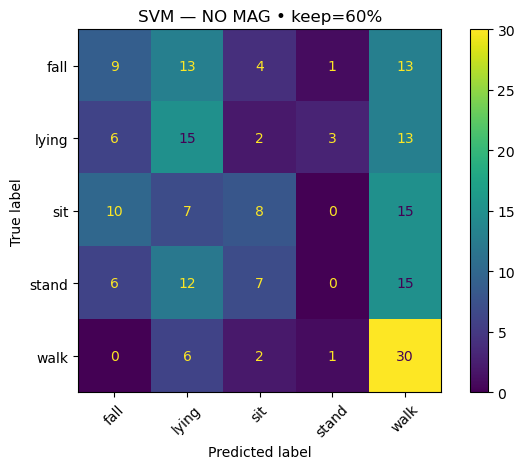


=== LR — NO MAG • keep=60% ===
Accuracy: 0.30808080808080807
              precision    recall  f1-score   support

        fall       0.18      0.07      0.11        40
       lying       0.29      0.38      0.33        39
         sit       0.43      0.33      0.37        40
       stand       0.43      0.07      0.13        40
        walk       0.29      0.69      0.41        39

    accuracy                           0.31       198
   macro avg       0.32      0.31      0.27       198
weighted avg       0.32      0.31      0.27       198



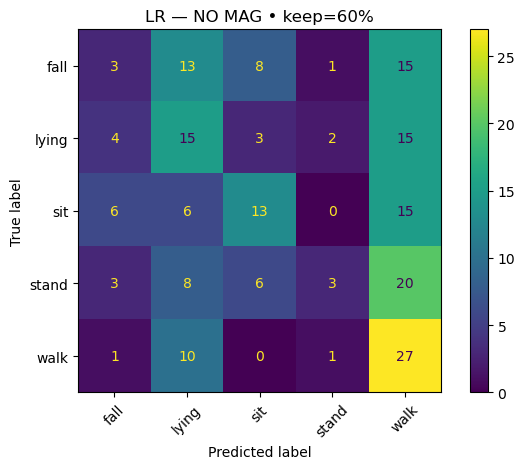


=== RF — NO MAG • keep=60% ===
Accuracy: 0.26262626262626265
              precision    recall  f1-score   support

        fall       0.17      0.10      0.13        40
       lying       0.21      0.23      0.22        39
         sit       0.38      0.25      0.30        40
       stand       0.25      0.03      0.05        40
        walk       0.27      0.72      0.40        39

    accuracy                           0.26       198
   macro avg       0.26      0.26      0.22       198
weighted avg       0.26      0.26      0.22       198



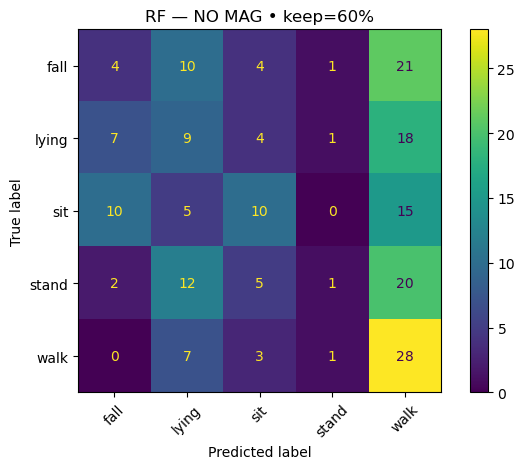


=== kNN — NO MAG • keep=60% ===
Accuracy: 0.3181818181818182
              precision    recall  f1-score   support

        fall       0.29      0.35      0.31        40
       lying       0.32      0.15      0.21        39
         sit       0.38      0.28      0.32        40
       stand       0.11      0.03      0.04        40
        walk       0.34      0.79      0.47        39

    accuracy                           0.32       198
   macro avg       0.29      0.32      0.27       198
weighted avg       0.29      0.32      0.27       198



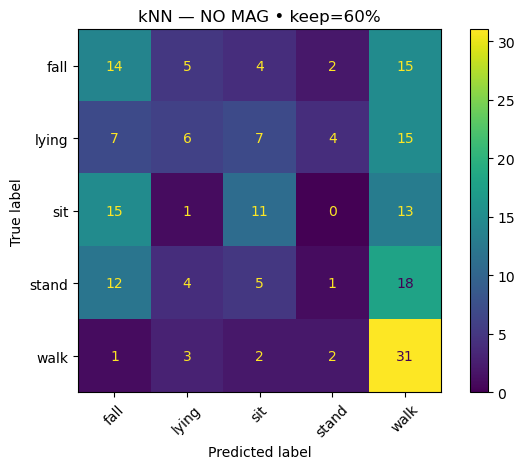


=== SVM — WITH MAG • keep=60% ===
Accuracy: 0.3888888888888889
              precision    recall  f1-score   support

        fall       0.75      0.07      0.14        40
       lying       0.40      0.54      0.46        39
         sit       0.38      0.62      0.47        40
       stand       0.30      0.17      0.22        40
        walk       0.40      0.54      0.46        39

    accuracy                           0.39       198
   macro avg       0.45      0.39      0.35       198
weighted avg       0.45      0.39      0.35       198



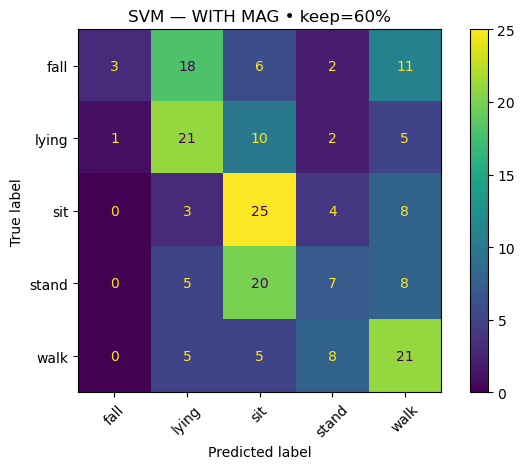


=== LR — WITH MAG • keep=60% ===
Accuracy: 0.3838383838383838
              precision    recall  f1-score   support

        fall       0.71      0.12      0.21        40
       lying       0.31      0.38      0.34        39
         sit       0.50      0.62      0.56        40
       stand       0.20      0.03      0.04        40
        walk       0.34      0.77      0.47        39

    accuracy                           0.38       198
   macro avg       0.41      0.39      0.33       198
weighted avg       0.41      0.38      0.33       198



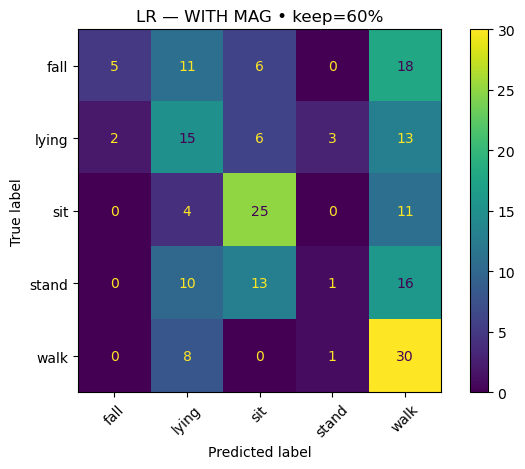


=== RF — WITH MAG • keep=60% ===
Accuracy: 0.3686868686868687
              precision    recall  f1-score   support

        fall       1.00      0.05      0.10        40
       lying       0.36      0.51      0.42        39
         sit       0.50      0.75      0.60        40
       stand       0.00      0.00      0.00        40
        walk       0.28      0.54      0.37        39

    accuracy                           0.37       198
   macro avg       0.43      0.37      0.30       198
weighted avg       0.43      0.37      0.30       198



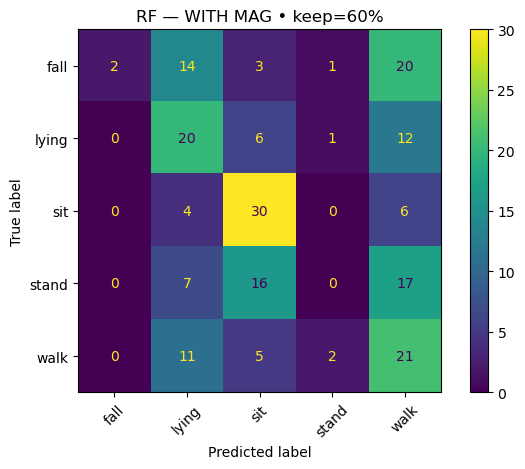


=== kNN — WITH MAG • keep=60% ===
Accuracy: 0.31313131313131315
              precision    recall  f1-score   support

        fall       0.56      0.12      0.20        40
       lying       0.42      0.26      0.32        39
         sit       0.28      0.65      0.39        40
       stand       0.30      0.07      0.12        40
        walk       0.29      0.46      0.35        39

    accuracy                           0.31       198
   macro avg       0.37      0.31      0.28       198
weighted avg       0.37      0.31      0.28       198



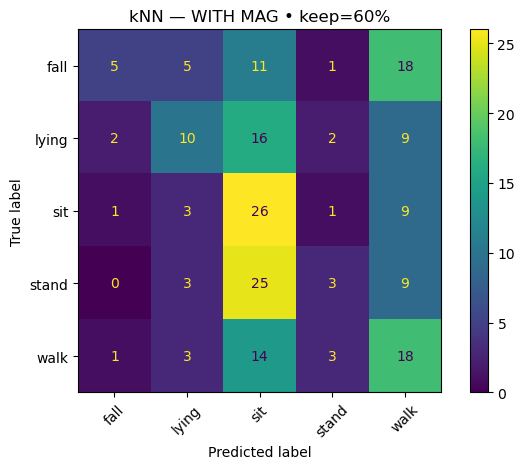


=== SVM — NO MAG • keep=80% ===
Accuracy: 0.20707070707070707
              precision    recall  f1-score   support

        fall       0.23      0.20      0.21        40
       lying       0.19      0.13      0.15        39
         sit       0.14      0.05      0.07        40
       stand       0.20      0.05      0.08        40
        walk       0.21      0.62      0.32        39

    accuracy                           0.21       198
   macro avg       0.19      0.21      0.17       198
weighted avg       0.19      0.21      0.17       198



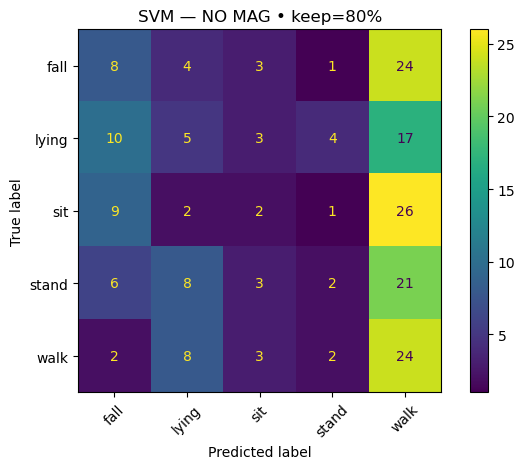


=== LR — NO MAG • keep=80% ===
Accuracy: 0.23737373737373738
              precision    recall  f1-score   support

        fall       0.11      0.03      0.04        40
       lying       0.30      0.26      0.28        39
         sit       0.33      0.07      0.12        40
       stand       0.50      0.05      0.09        40
        walk       0.22      0.79      0.34        39

    accuracy                           0.24       198
   macro avg       0.29      0.24      0.17       198
weighted avg       0.29      0.24      0.17       198



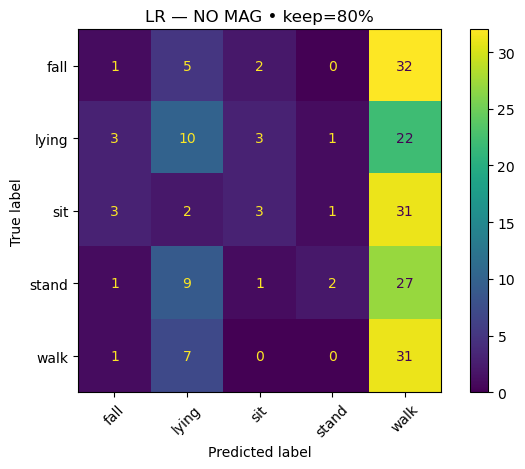


=== RF — NO MAG • keep=80% ===
Accuracy: 0.21717171717171718
              precision    recall  f1-score   support

        fall       0.00      0.00      0.00        40
       lying       0.30      0.28      0.29        39
         sit       0.41      0.17      0.25        40
       stand       0.50      0.03      0.05        40
        walk       0.18      0.62      0.28        39

    accuracy                           0.22       198
   macro avg       0.28      0.22      0.17       198
weighted avg       0.28      0.22      0.17       198



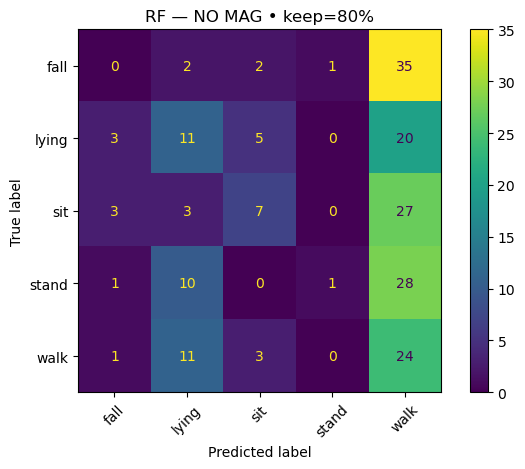


=== kNN — NO MAG • keep=80% ===
Accuracy: 0.26262626262626265
              precision    recall  f1-score   support

        fall       0.30      0.28      0.29        40
       lying       0.44      0.10      0.17        39
         sit       0.21      0.07      0.11        40
       stand       0.29      0.05      0.09        40
        walk       0.24      0.82      0.38        39

    accuracy                           0.26       198
   macro avg       0.30      0.26      0.21       198
weighted avg       0.30      0.26      0.20       198



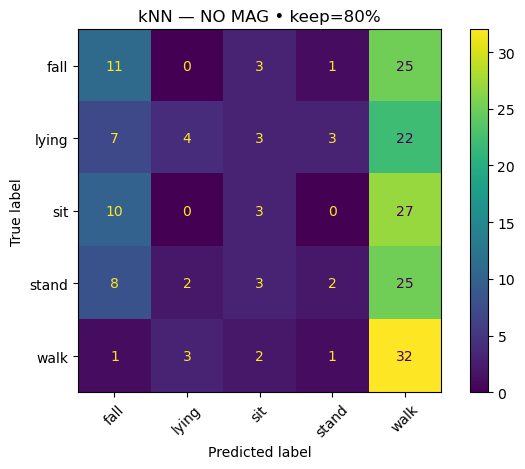


=== SVM — WITH MAG • keep=80% ===
Accuracy: 0.30303030303030304
              precision    recall  f1-score   support

        fall       0.00      0.00      0.00        40
       lying       0.37      0.49      0.42        39
         sit       0.32      0.82      0.46        40
       stand       0.06      0.03      0.04        40
        walk       0.24      0.18      0.21        39

    accuracy                           0.30       198
   macro avg       0.20      0.30      0.23       198
weighted avg       0.20      0.30      0.22       198



C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


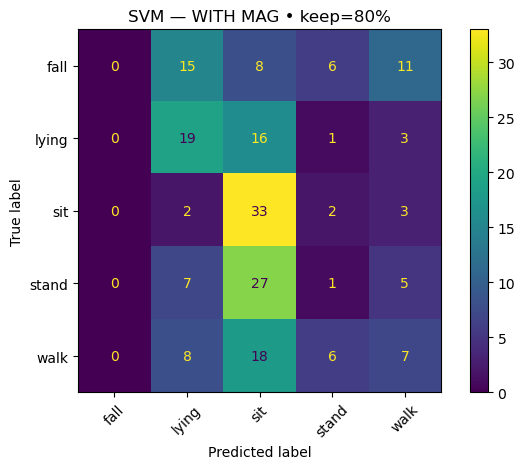


=== LR — WITH MAG • keep=80% ===
Accuracy: 0.25252525252525254
              precision    recall  f1-score   support

        fall       0.50      0.03      0.05        40
       lying       0.19      0.28      0.23        39
         sit       0.39      0.30      0.34        40
       stand       0.33      0.03      0.05        40
        walk       0.24      0.64      0.35        39

    accuracy                           0.25       198
   macro avg       0.33      0.25      0.20       198
weighted avg       0.33      0.25      0.20       198



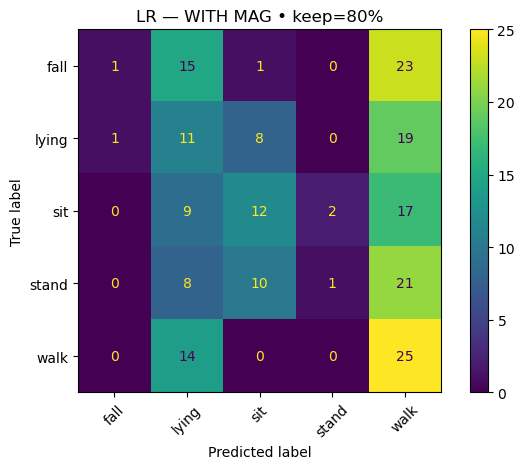


=== RF — WITH MAG • keep=80% ===
Accuracy: 0.2828282828282828
              precision    recall  f1-score   support

        fall       0.00      0.00      0.00        40
       lying       0.35      0.38      0.37        39
         sit       0.39      0.57      0.46        40
       stand       0.00      0.00      0.00        40
        walk       0.19      0.46      0.27        39

    accuracy                           0.28       198
   macro avg       0.19      0.28      0.22       198
weighted avg       0.19      0.28      0.22       198



C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


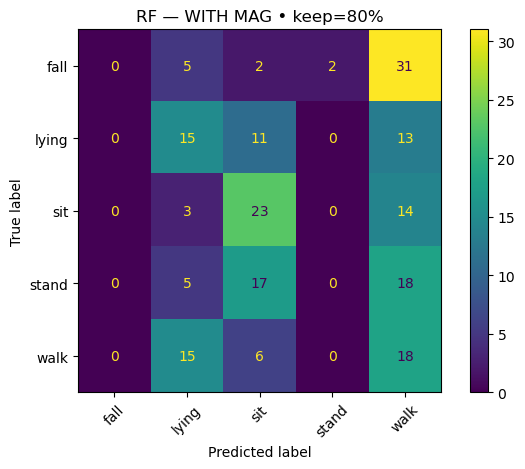


=== kNN — WITH MAG • keep=80% ===
Accuracy: 0.29292929292929293
              precision    recall  f1-score   support

        fall       0.20      0.03      0.04        40
       lying       0.45      0.26      0.33        39
         sit       0.26      0.68      0.38        40
       stand       0.17      0.03      0.04        40
        walk       0.31      0.49      0.38        39

    accuracy                           0.29       198
   macro avg       0.28      0.29      0.23       198
weighted avg       0.28      0.29      0.23       198



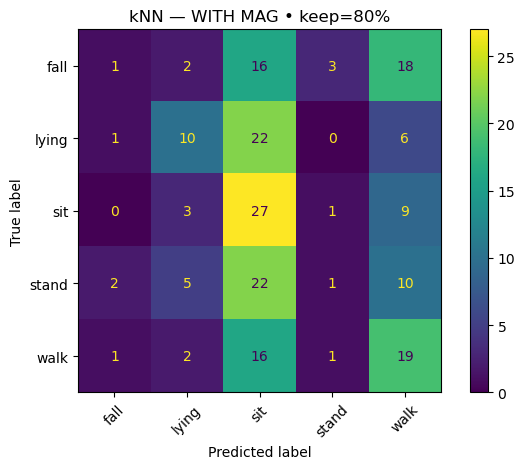


=== SVM — NO MAG • keep=100% ===
Accuracy: 0.1717171717171717
              precision    recall  f1-score   support

        fall       0.20      0.05      0.08        40
       lying       0.28      0.13      0.18        39
         sit       0.10      0.15      0.12        40
       stand       0.14      0.05      0.07        40
        walk       0.19      0.49      0.28        39

    accuracy                           0.17       198
   macro avg       0.18      0.17      0.15       198
weighted avg       0.18      0.17      0.15       198



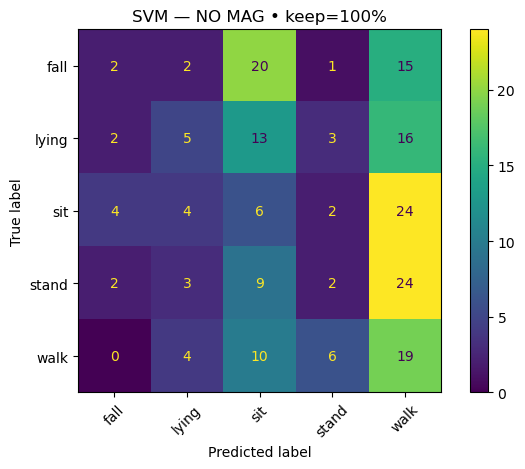


=== LR — NO MAG • keep=100% ===
Accuracy: 0.20707070707070707
              precision    recall  f1-score   support

        fall       0.00      0.00      0.00        40
       lying       0.36      0.10      0.16        39
         sit       1.00      0.03      0.05        40
       stand       0.00      0.00      0.00        40
        walk       0.20      0.92      0.32        39

    accuracy                           0.21       198
   macro avg       0.31      0.21      0.11       198
weighted avg       0.31      0.21      0.11       198



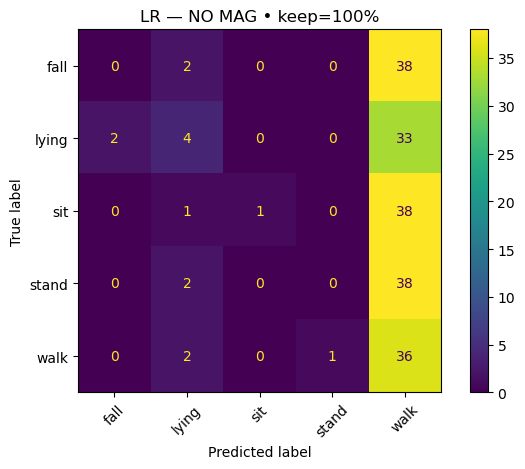


=== RF — NO MAG • keep=100% ===
Accuracy: 0.24242424242424243
              precision    recall  f1-score   support

        fall       0.00      0.00      0.00        40
       lying       0.43      0.26      0.32        39
         sit       0.40      0.10      0.16        40
       stand       0.00      0.00      0.00        40
        walk       0.21      0.87      0.33        39

    accuracy                           0.24       198
   macro avg       0.21      0.25      0.16       198
weighted avg       0.21      0.24      0.16       198



C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


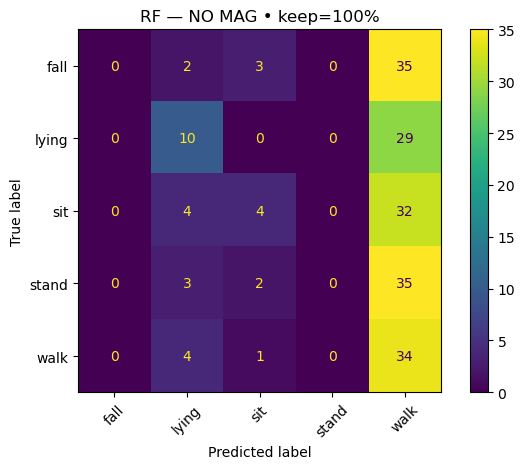


=== kNN — NO MAG • keep=100% ===
Accuracy: 0.20202020202020202
              precision    recall  f1-score   support

        fall       0.12      0.05      0.07        40
       lying       0.33      0.03      0.05        39
         sit       0.00      0.00      0.00        40
       stand       0.20      0.03      0.04        40
        walk       0.21      0.92      0.34        39

    accuracy                           0.20       198
   macro avg       0.17      0.20      0.10       198
weighted avg       0.17      0.20      0.10       198



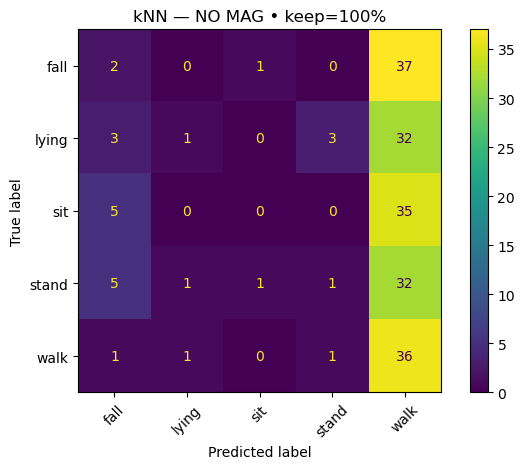


=== SVM — WITH MAG • keep=100% ===
Accuracy: 0.25757575757575757
              precision    recall  f1-score   support

        fall       0.00      0.00      0.00        40
       lying       0.36      0.26      0.30        39
         sit       0.24      1.00      0.39        40
       stand       0.33      0.03      0.05        40
        walk       0.00      0.00      0.00        39

    accuracy                           0.26       198
   macro avg       0.19      0.26      0.15       198
weighted avg       0.19      0.26      0.15       198



C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


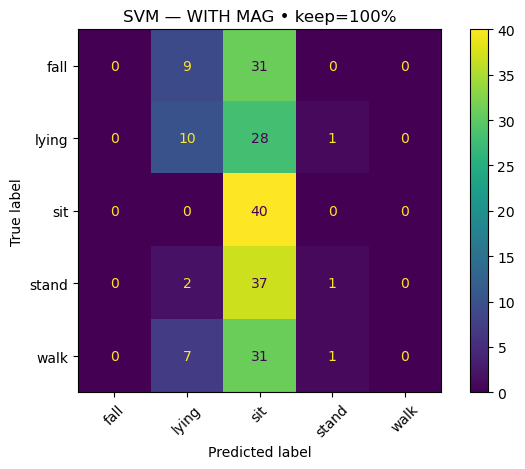


=== LR — WITH MAG • keep=100% ===
Accuracy: 0.23737373737373738
              precision    recall  f1-score   support

        fall       0.00      0.00      0.00        40
       lying       0.25      0.31      0.28        39
         sit       0.67      0.10      0.17        40
       stand       0.33      0.03      0.05        40
        walk       0.21      0.77      0.33        39

    accuracy                           0.24       198
   macro avg       0.29      0.24      0.17       198
weighted avg       0.29      0.24      0.16       198



C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


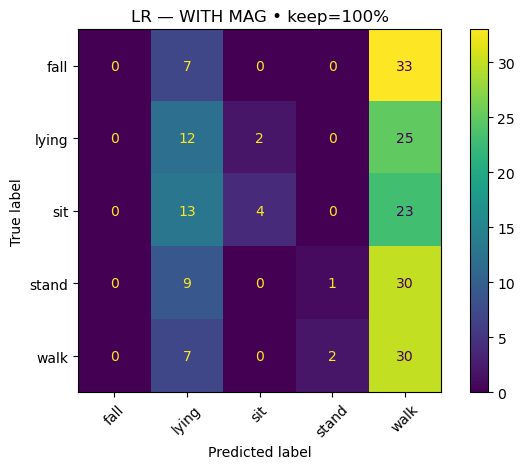


=== RF — WITH MAG • keep=100% ===
Accuracy: 0.3333333333333333
              precision    recall  f1-score   support

        fall       0.00      0.00      0.00        40
       lying       0.50      0.31      0.38        39
         sit       0.38      0.57      0.46        40
       stand       0.00      0.00      0.00        40
        walk       0.27      0.79      0.41        39

    accuracy                           0.33       198
   macro avg       0.23      0.34      0.25       198
weighted avg       0.23      0.33      0.25       198



C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\USER\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


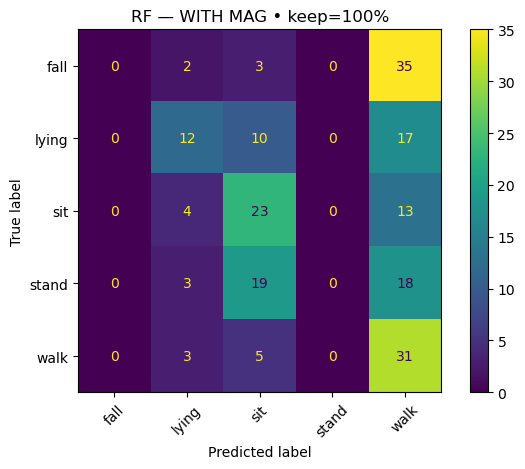


=== kNN — WITH MAG • keep=100% ===
Accuracy: 0.2676767676767677
              precision    recall  f1-score   support

        fall       0.33      0.03      0.05        40
       lying       0.42      0.26      0.32        39
         sit       0.26      0.55      0.35        40
       stand       0.00      0.00      0.00        40
        walk       0.25      0.51      0.34        39

    accuracy                           0.27       198
   macro avg       0.25      0.27      0.21       198
weighted avg       0.25      0.27      0.21       198



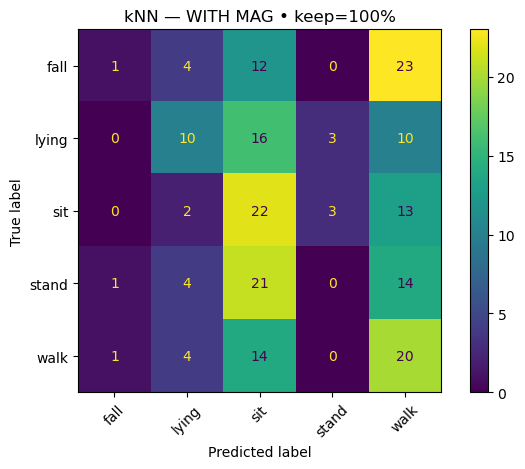


=== Summary (train=30%, test on remaining thresholds) ===
 keep_top_pct  variant  SVM_acc   SVM_f1   LR_acc    LR_f1   RF_acc    RF_f1  kNN_acc   kNN_f1  n_test  dropped
           60   NO MAG 0.313131 0.262715 0.308081 0.269247 0.262626 0.218429 0.318182 0.270889     198        0
           60 WITH MAG 0.388889 0.349669 0.383838 0.326007 0.368687 0.296302 0.313131 0.277685     198        0
           80   NO MAG 0.207071 0.167361 0.237374 0.174522 0.217172 0.172033 0.262626 0.205014     198        0
           80 WITH MAG 0.303030 0.225722 0.252525 0.201710 0.282828 0.220235 0.292929 0.233930     198        0
          100   NO MAG 0.171717 0.145867 0.207071 0.106621 0.242424 0.163183 0.202020 0.100945     198        0
          100 WITH MAG 0.257576 0.146299 0.237374 0.165924 0.333333 0.249236 0.267677 0.210421     198        0


In [9]:
import os, glob, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

#
#-----------------Training on Clean - testing on 30,60,80,100------------------
#

#config
DATA_DIR = r"C:\Users\USER\precomputed_pointclouds\magnitude"
RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

SPLIT_MODE = "stratified"      
TEST_SIZE = 0.20               
HOLDOUT_FRAMES_PER_FILE = 10   

# DBSCAN clustering
DBSCAN_EPS = 0.12
DBSCAN_MIN_SAMPLES = 8
CLUSTER_BY_MAG_FOR_BOTH = False

CYL_Z_BINS = 6
CYL_R_BINS = 6
CONST_BIN_STD_EPS = 1e-8  

#Define clean training threshold and the test thresholds
TRAIN_KEEP = 0.30
TEST_KEEPS = [0.60, 0.80, 1.00]   #evaluating on the remaining sets

#Plotting
PLOT_CM = True

#reusing same functions
def _clean_mag_pc(pc):
    """Ensure (N,4) float32 [x,y,z,mag]. Accepts (N,3) -> pads mag=0. Drops non-finite."""
    if pc is None:
        return np.zeros((0,4), np.float32)
    arr = np.asarray(pc)
    if arr.ndim == 1:
        arr = np.atleast_2d(arr)
    if arr.shape[1] == 3:
        arr = np.column_stack([arr, np.zeros((arr.shape[0],), dtype=arr.dtype)])
    if arr.ndim != 2 or arr.shape[1] != 4:
        return np.zeros((0,4), np.float32)
    arr = arr.astype(np.float32, copy=False)
    return arr[np.isfinite(arr).all(axis=1)]

def _robust_scale_magnitudes(m):
    med = np.median(m)
    q1, q3 = np.percentile(m, [25, 75])
    iqr = q3 - q1
    if iqr < 1e-6:
        s = np.std(m) + 1e-6
        return (m - med) / s
    return (m - med) / (iqr + 1e-6)

def _choose_cluster(xyz, mag_norm, by_mag=False):
    from sklearn.cluster import DBSCAN as _DB
    labels = _DB(eps=DBSCAN_EPS, min_samples=DBSCAN_MIN_SAMPLES).fit_predict(xyz)
    if np.all(labels == -1):
        return np.ones(xyz.shape[0], dtype=bool)
    best_lbl, best_score = None, -1.0
    for lbl in np.unique(labels):
        if lbl == -1:
            continue
        idx = (labels == lbl)
        score = mag_norm[idx].sum() if by_mag else idx.sum()
        if score > best_score:
            best_score, best_lbl = score, lbl
    if best_lbl is None:
        return np.ones(xyz.shape[0], dtype=bool)
    return labels == best_lbl

def _eigen_features(X):
    if X.shape[0] < 3:
        return np.zeros(5, dtype=float)
    C = np.cov(X.T)
    vals = np.sort(np.maximum(np.linalg.eigvalsh(C), 1e-12))[::-1]
    l1, l2, l3 = vals
    linearity  = (l1 - l2) / (l1 + 1e-12)
    planarity  = (l2 - l3) / (l1 + 1e-12)
    scattering =  l3 / (l1 + 1e-12)
    sphericity =  l3 / (l1 + l2 + l3 + 1e-12)
    anisotropy = (l1 - l3) / (l1 + 1e-12)
    return np.array([linearity, planarity, scattering, sphericity, anisotropy], float)

def _cyl_hist(Xn):
    z = Xn[:,2]
    r = np.sqrt(Xn[:,0]**2 + Xn[:,1]**2)
    z_edges = np.linspace(0, 1, CYL_Z_BINS+1)
    r_edges = np.linspace(0, np.percentile(r, 95)+1e-6, CYL_R_BINS+1)
    H, _, _ = np.histogram2d(z, r, bins=[z_edges, r_edges])
    H = H / (H.sum() + 1e-9)
    return H.ravel()

def extract_features(arr, use_mag_features=False, cluster_by_mag=False, keep_top_pct=1.0):
    if arr.size == 0:
        return None
    x,y,z,mag = arr.T
    if mag.size < 40:
        return None

    # robust mag scaling -> filter top p%
    m_norm = _robust_scale_magnitudes(mag)
    k = int(max(1, np.floor((1.0 - keep_top_pct) * m_norm.size)))
    thr = np.partition(m_norm, k)[k]
    keep = m_norm >= thr
    if keep.sum() < 30:
        return None
    xyz = arr[keep, :3]
    m_kept = m_norm[keep]

    # cluster & select target blob
    mask = _choose_cluster(xyz, m_kept, by_mag=cluster_by_mag)
    xyz = xyz[mask, :]
    m_kept = m_kept[mask]
    if xyz.shape[0] < 30:
        return None

    # density (points per bbox volume)
    mins = xyz.min(axis=0); maxs = xyz.max(axis=0)
    ext = np.maximum(maxs - mins, 1e-6)
    bbox_vol = float(ext[0]*ext[1]*ext[2])
    density = float(xyz.shape[0]) / bbox_vol

    # normalise by height; compute z/r stats
    centroid = xyz.mean(axis=0)
    Xc = xyz - centroid
    z_range = np.ptp(xyz[:,2])
    scale = z_range if z_range > 1e-6 else 1.0
    Xn = Xc / scale
    zn = (xyz[:,2] - xyz[:,2].min()) / (z_range + 1e-9)
    r = np.sqrt(Xn[:,0]**2 + Xn[:,1]**2)

    # shared geometry features
    z_q10, z_q50, z_q90 = np.quantile(zn, [0.10, 0.50, 0.90])
    r_mean, r_std = r.mean(), r.std()
    eig = _eigen_features(Xn)
    hist = _cyl_hist(Xn)

    if use_mag_features:
        mg_mean, mg_std, mg_max = m_kept.mean(), m_kept.std(), m_kept.max()
        geom = np.array([z_range, density, z_q10, z_q50, z_q90, r_mean, r_std], float)
        feat = np.concatenate([
            np.array([mg_mean, mg_std, mg_max], float),  # 3 mag moments
            geom,                                       # 7
            eig,                                        # 5
            hist                                        # 36
        ])  # 51
    else:
        feat = np.concatenate([
            np.array([z_range, density, z_q10, z_q50, z_q90, r_mean, r_std], float),
            eig,
            hist
        ])  # 48

    return feat

#loading data
def load_raw_frames(data_dir):
    frames, labels, file_ids = [], [], []
    next_fid = 0
    files_used = 0

    for path in sorted(glob.glob(os.path.join(data_dir, "*.npz"))):
        d = np.load(path, allow_pickle=True)
        if "pcs" not in d.files or "label" not in d.files:
            continue
        pcs = list(d["pcs"])
        label = str(d["label"])
        added = 0
        for pc in pcs:
            arr = _clean_mag_pc(pc)
            frames.append(arr)
            labels.append(label)
            file_ids.append(next_fid)
            added += 1
        if added > 0:
            next_fid += 1
            files_used += 1

    if not frames:
        raise RuntimeError("No frames found. Check DATA_DIR or file contents.")
    print(f"[INFO] Raw files: {files_used} | Raw frames: {len(frames)}")
    return frames, np.array(labels, dtype=object), np.array(file_ids, dtype=int)

#extracting features for both mag and no mag runs
def build_features_for_both(frames, keep_top_pct=1.0, cluster_by_mag=CLUSTER_BY_MAG_FOR_BOTH):
    feats_mag, mask_mag = [], []
    feats_nomag, mask_nomag = [], []

    for arr in frames:
        f1 = extract_features(arr, use_mag_features=True,  cluster_by_mag=cluster_by_mag, keep_top_pct=keep_top_pct)
        f2 = extract_features(arr, use_mag_features=False, cluster_by_mag=cluster_by_mag, keep_top_pct=keep_top_pct)
        if f1 is None:
            mask_mag.append(False)
        else:
            feats_mag.append(f1); mask_mag.append(True)
        if f2 is None:
            mask_nomag.append(False)
        else:
            feats_nomag.append(f2); mask_nomag.append(True)

    mask_mag = np.array(mask_mag, bool)
    mask_nomag = np.array(mask_nomag, bool)
    usable_idx = np.where(mask_mag & mask_nomag)[0]

    X_mag_all   = [extract_features(frames[i], use_mag_features=True,  cluster_by_mag=cluster_by_mag, keep_top_pct=keep_top_pct)  for i in usable_idx]
    X_nomag_all = [extract_features(frames[i], use_mag_features=False, cluster_by_mag=cluster_by_mag, keep_top_pct=keep_top_pct)  for i in usable_idx]

    X_mag   = np.asarray(X_mag_all,   dtype=float)
    X_nomag = np.asarray(X_nomag_all, dtype=float)
    return X_mag, X_nomag, usable_idx

#defining split
def make_split(labels_common, file_ids_common, mode="stratified",
               test_size=TEST_SIZE, holdout_per_file=HOLDOUT_FRAMES_PER_FILE, seed=RANDOM_STATE):
    n = len(labels_common)
    if mode == "stratified":
        le_tmp = LabelEncoder().fit(labels_common)
        y_enc = le_tmp.transform(labels_common)
        sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=seed)
        (tr_idx, te_idx), = sss.split(np.zeros(n), y_enc)
        return tr_idx, te_idx
    elif mode == "per_file_holdout":
        rng = random.Random(seed)
        idx_by_fid = {}
        for i, fid in enumerate(file_ids_common):
            idx_by_fid.setdefault(fid, []).append(i)
        tr, te = [], []
        for fid, idxs in idx_by_fid.items():
            idxs = idxs[:]  
            rng.shuffle(idxs)
            take = min(holdout_per_file, max(1, len(idxs)//6)) 
            te.extend(idxs[:take])
            tr.extend(idxs[take:])
        rng.shuffle(tr); rng.shuffle(te)
        return np.array(tr, dtype=int), np.array(te, dtype=int)
    else:
        raise ValueError("SPLIT_MODE must be 'stratified' or 'per_file_holdout'.")

### Training and evaluating
def prune_constant_bins(Xtr):
    stds = Xtr.std(axis=0)
    keep = stds >= CONST_BIN_STD_EPS
    dropped = np.where(~keep)[0].tolist()
    if dropped:
        print(f"[INFO] Dropped {len(dropped)} near-constant features.")
    return keep

#finds best hyperparameters for model
def _fit_gs(pipe, grid, X, y):
    gs = GridSearchCV(pipe, grid, cv=3, scoring="f1_macro", n_jobs=-1)
    gs.fit(X, y)
    return gs.best_estimator_, gs.best_params_

#runs trained model on test data
def _predict_report(name, est, Xte, yte, labels, plot=PLOT_CM):
    yp = est.predict(Xte)
    acc = accuracy_score(yte, yp)
    f1m = f1_score(yte, yp, average="macro")
    print(f"\n=== {name} ===")
    print("Accuracy:", acc)
    print(classification_report(yte, yp, target_names=labels))
    if plot:
        cm = confusion_matrix(yte, yp, labels=np.unique(yte))
        ConfusionMatrixDisplay(cm, display_labels=labels).plot(xticks_rotation=45)
        plt.title(name); plt.tight_layout(); plt.show()
    return acc, f1m

#trains models on clean (30% data)
def train_models_on_clean(X_train, y_train, label_names, tag):
    keep_mask = prune_constant_bins(X_train)

    Xtr2 = X_train[:, keep_mask]

    #Pipelines
    svm = Pipeline([("scaler", StandardScaler()),
                    ("svc", SVC(kernel="rbf", decision_function_shape="ovr"))])
    svm_grid = {"svc__C":[0.5,1,2,5,10],
                "svc__gamma":["scale",0.1,0.05,0.01],
                "svc__class_weight":[None,"balanced"]}

    lr = Pipeline([("scaler", StandardScaler()),
                   ("lr", LogisticRegression(max_iter=2000, n_jobs=-1, multi_class="auto"))])
    lr_grid = {"lr__C":[0.1, 1, 5, 10],
               "lr__penalty":["l2"],
               "lr__class_weight":[None, "balanced"]}

    rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
    rf_grid = {"n_estimators":[200, 400],
               "max_depth":[None, 10, 20],
               "min_samples_split":[2, 5],
               "min_samples_leaf":[1, 2],
               "class_weight":[None, "balanced"]}

    knn = Pipeline([("scaler", StandardScaler()),
                    ("knn", KNeighborsClassifier())])
    knn_grid = {"knn__n_neighbors":[3,5,7,9,11],
                "knn__weights":["uniform","distance"],
                "knn__p":[1,2]}

    models = {}
    models["SVM"], models["SVM_best"] = _fit_gs(svm, svm_grid, Xtr2, y_train)
    models["LR"],  models["LR_best"]  = _fit_gs(lr,  lr_grid,  Xtr2, y_train)
    models["RF"],  models["RF_best"]  = _fit_gs(rf,  rf_grid,  Xtr2, y_train)
    models["kNN"], models["kNN_best"] = _fit_gs(knn, knn_grid, Xtr2, y_train)

    print(f"\n[INFO] Finished training on clean set — {tag}")
    return models, keep_mask


#tests and evaluates trained model performance on varied noise levels
def evaluate_on_threshold(models, keep_mask, X_all, y_all, usable_idx, te_globals, label_encoder, label_names, tag):
    pos = {g: i for i, g in enumerate(usable_idx)}
    take = [pos[g] for g in te_globals if g in pos]
    dropped = len(te_globals) - len(take)
    if dropped > 0:
        print(f"[WARN] {tag}: dropped {dropped}/{len(te_globals)} test frames (unusable at this threshold).")

    if len(take) == 0:
        print(f"[WARN] {tag}: no overlapping test frames — skipping.")
        return None

    Xte = X_all[take][:, keep_mask]
    yte = label_encoder.transform(y_all[usable_idx[take]])

    out = {}
    for name in ["SVM","LR","RF","kNN"]:
        acc, f1m = _predict_report(f"{name} — {tag}", models[name], Xte, yte, label_names, plot=PLOT_CM)
        out[f"{name}_acc"] = acc
        out[f"{name}_f1"]  = f1m
    out["n_test"] = len(take)
    out["dropped"] = dropped
    return out

#main 
if __name__ == "__main__":
    frames, labels_all, file_ids_all = load_raw_frames(DATA_DIR)

    #build features
    X_mag_tr, X_nomag_tr, usable_idx_tr = build_features_for_both(frames, keep_top_pct=TRAIN_KEEP,
                                                                  cluster_by_mag=CLUSTER_BY_MAG_FOR_BOTH)
    labels_tr_common   = labels_all[usable_idx_tr]
    file_ids_tr_common = file_ids_all[usable_idx_tr]

    print(f"[INFO] CLEAN (keep=30%) usable frames: {len(labels_tr_common)} | "
          f"X_mag dim: {X_mag_tr.shape[1]} | X_nomag dim: {X_nomag_tr.shape[1]}")
    print("Class counts (clean/common):\n", pd.Series(labels_tr_common).value_counts())

    #test train split, ensures same test files used for all evaluations
    tr_idx, te_idx = make_split(labels_tr_common, file_ids_tr_common, mode=SPLIT_MODE,
                                test_size=TEST_SIZE, holdout_per_file=HOLDOUT_FRAMES_PER_FILE, seed=RANDOM_STATE)
    te_globals = usable_idx_tr[te_idx]   # global frame indices forming THE test set

    le = LabelEncoder().fit(labels_tr_common)
    y_enc_tr = le.transform(labels_tr_common)
    label_names = le.classes_

    #trains models on clean data for both mag and nomag
    # NO MAG
    models_nomag, keep_nomag = train_models_on_clean(X_nomag_tr[tr_idx], y_enc_tr[tr_idx],
                                                     label_names, tag="NO MAG • keep=30%")
    # WITH MAG
    models_mag, keep_mag = train_models_on_clean(X_mag_tr[tr_idx], y_enc_tr[tr_idx],
                                                 label_names, tag="WITH MAG • keep=30%")

    #evalates on other noise levels via thresholds 60,80,100
    results = []
    for keep in TEST_KEEPS:
        X_mag_te, X_nomag_te, usable_idx_te = build_features_for_both(frames, keep_top_pct=keep,
                                                                      cluster_by_mag=CLUSTER_BY_MAG_FOR_BOTH)
        tag_base = f"keep={int(keep*100)}%"

        #NO MAG eval
        res_nomag = evaluate_on_threshold(models_nomag, keep_nomag, X_nomag_te, labels_all,
                                          usable_idx_te, te_globals, le, label_names,
                                          tag=f"NO MAG • {tag_base}")
        if res_nomag is not None:
            row = {"keep_top_pct": int(keep*100), "variant":"NO MAG"}
            row.update(res_nomag)
            results.append(row)

        #WITH MAG eval
        res_mag = evaluate_on_threshold(models_mag, keep_mag, X_mag_te, labels_all,
                                        usable_idx_te, te_globals, le, label_names,
                                        tag=f"WITH MAG • {tag_base}")
        if res_mag is not None:
            row = {"keep_top_pct": int(keep*100), "variant":"WITH MAG"}
            row.update(res_mag)
            results.append(row)

    #print summary
    summary = pd.DataFrame(results).sort_values(["keep_top_pct","variant"])
    print("\n=== Summary (train=30%, test on remaining thresholds) ===")
    print(summary.to_string(index=False))


In [10]:
import os, glob, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

#imports for pytorch
try:
    import torch
    import torch.nn as nn
    from torch.utils.data import TensorDataset, DataLoader
    TORCH_AVAILABLE = True
except Exception:
    TORCH_AVAILABLE = False

#config
DATA_DIR = r"C:\Users\USER\precomputed_pointclouds\magnitude"
RANDOM_STATE = 42
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

#defining noise levels
KEEPS = [0.30, 0.60, 0.80, 1.00]  # 30/60/80/100

#Clustering & point filtering
DBSCAN_EPS = 0.16         #looser to retain structure for cnn classification
DBSCAN_MIN_SAMPLES = 6
CLUSTER_BY_MAG = True     #magnitude-guided cluster selection to aid model on relatively limited data for cnn

#training params
MAX_POINTS = 1024
BATCH_SIZE = 64
EPOCHS = 15
LR = 1e-3
VAL_SPLIT = 0.2
NUM_WORKERS = 0
PLOT_CM = False           

#reuse of functions
def _clean_mag_pc(pc):
    if pc is None:
        return np.zeros((0,4), np.float32)
    arr = np.asarray(pc)
    if arr.ndim == 1:
        arr = np.atleast_2d(arr)
    if arr.shape[1] == 3:
        arr = np.column_stack([arr, np.zeros((arr.shape[0],), dtype=arr.dtype)])
    if arr.ndim != 2 or arr.shape[1] != 4:
        return np.zeros((0,4), np.float32)
    arr = arr.astype(np.float32, copy=False)
    return arr[np.isfinite(arr).all(axis=1)]

def _robust_scale_magnitudes(m):
    med = np.median(m)
    q1, q3 = np.percentile(m, [25, 75])
    iqr = q3 - q1
    if iqr < 1e-6:
        s = np.std(m) + 1e-6
        return (m - med) / s
    return (m - med) / (iqr + 1e-6)

def _choose_cluster(xyz, mag_norm, by_mag=False):
    from sklearn.cluster import DBSCAN as _DB
    labels = _DB(eps=DBSCAN_EPS, min_samples=DBSCAN_MIN_SAMPLES).fit_predict(xyz)
    if np.all(labels == -1):
        return np.ones(xyz.shape[0], dtype=bool)
    best_lbl, best_score = None, -1.0
    for lbl in np.unique(labels):
        if lbl == -1:
            continue
        idx = (labels == lbl)
        score = mag_norm[idx].sum() if by_mag else idx.sum()
        if score > best_score:
            best_score, best_lbl = score, lbl
    if best_lbl is None:
        return np.ones(xyz.shape[0], dtype=bool)
    return labels == best_lbl

#converting raw point clouds to tesors for cnn training
def build_point_tensor(arr, keep_top_pct, include_mag=True, cluster_by_mag=CLUSTER_BY_MAG, max_points=MAX_POINTS):
    if arr is None or arr.size == 0:
        return None
    x,y,z,mag = arr.T
    if mag.size < 40:
        return None

    #mag scaling
    m_norm = _robust_scale_magnitudes(mag)
    k = int(max(1, np.floor((1.0 - keep_top_pct) * m_norm.size)))
    thr = np.partition(m_norm, k)[k]
    keep = m_norm >= thr
    if keep.sum() < 30:
        return None

    xyz = arr[keep, :3]
    m_kept = m_norm[keep]

    #cluster selection
    mask = _choose_cluster(xyz, m_kept, by_mag=cluster_by_mag)
    xyz = xyz[mask, :]
    m_kept = m_kept[mask]
    if xyz.shape[0] < 30:
        return None

    #center cloud at centroid
    centroid = xyz.mean(axis=0)
    Xc = xyz - centroid
    z_range = np.ptp(xyz[:,2])
    scale = z_range if z_range > 1e-6 else 1.0
    Xn = Xc / scale

    if include_mag:
        pts = np.column_stack([Xn, m_kept]).astype(np.float32)  # (N,4)
    else:
        pts = Xn.astype(np.float32)                              # (N,3)

    N, C = pts.shape
    if N >= max_points:
        sel = np.random.choice(N, size=max_points, replace=False)
        out = pts[sel]
    else:
        out = np.zeros((max_points, C), dtype=np.float32)
        out[:N] = pts
    return out

#loading raw .npz files as point clouds with labels
def load_raw_frames(data_dir):
    frames, labels, file_ids = [], [], []
    next_fid = 0
    files_used = 0
    for path in sorted(glob.glob(os.path.join(data_dir, "*.npz"))):
        d = np.load(path, allow_pickle=True)
        if "pcs" not in d.files or "label" not in d.files:
            continue
        pcs = list(d["pcs"])
        label = str(d["label"]).strip()
        added = 0
        for pc in pcs:
            frames.append(_clean_mag_pc(pc))
            labels.append(label)
            file_ids.append(next_fid)
            added += 1
        if added > 0:
            next_fid += 1
            files_used += 1
    if not frames:
        raise RuntimeError("No frames found. Check DATA_DIR or file contents.")
    print(f"[INFO] Raw files: {files_used} | Raw frames: {len(frames)}")
    return frames, np.array(labels, dtype=object), np.array(file_ids, dtype=int)

#preprocesses all frames into tensors for set noise level -- keep_top_pct
def tensors_for_noise(frames, labels_all, keep_top_pct, include_mag):
    tensors, labs, gids = [], [], []
    for gi, arr in enumerate(frames):
        t = build_point_tensor(arr, keep_top_pct=keep_top_pct, include_mag=include_mag)
        if t is not None:
            tensors.append(t); labs.append(labels_all[gi]); gids.append(gi)
    if len(tensors) == 0:
        return np.zeros((0, MAX_POINTS, 4 if include_mag else 3), np.float32), np.array([], object), np.array([], int)
    return np.asarray(tensors, np.float32), np.asarray(labs, object), np.asarray(gids, int)


#point net implementation
class PointNetLite(nn.Module):
    def __init__(self, in_ch=4, num_classes=2):
        super().__init__()
        self.feat = nn.Sequential(
            nn.Conv1d(in_ch, 64, 1), nn.ReLU(inplace=True),
            nn.Conv1d(64, 128, 1),   nn.ReLU(inplace=True),
            nn.Conv1d(128, 256, 1),  nn.ReLU(inplace=True),
        )
        #classification head
        self.cls = nn.Sequential(
            nn.Linear(256, 128), nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):             
        x = x.transpose(1, 2)         
        f = self.feat(x)              
        g = torch.max(f, dim=2).values
        return self.cls(g)

    #set seeds for reproduciability
def set_seeds(seed=RANDOM_STATE):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)

    #wrap np arrays into pytorch dataset and loader
def mk_loader(X, y, train=True):
    ds = TensorDataset(torch.from_numpy(X), torch.from_numpy(y))
    return DataLoader(ds, batch_size=BATCH_SIZE, shuffle=train, num_workers=NUM_WORKERS, drop_last=False)

#train pointnet model with small val split
def train_pointnet(Xtr, ytr, in_ch, num_classes):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #stratified val split
    y_np = ytr.copy()
    sss = StratifiedShuffleSplit(n_splits=1, test_size=VAL_SPLIT, random_state=RANDOM_STATE)
    (tr_idx, va_idx), = sss.split(np.zeros(len(y_np)), y_np)
    X_tr, y_tr = Xtr[tr_idx], ytr[tr_idx]
    X_va, y_va = Xtr[va_idx], ytr[va_idx]

    #initialize model, optimizer and loss
    model = PointNetLite(in_ch=in_ch, num_classes=num_classes).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-4)
    crit = nn.CrossEntropyLoss()

    dl_tr = mk_loader(X_tr, y_tr, train=True)
    dl_va = mk_loader(X_va, y_va, train=False)

    
    #training loop
    best_acc, best_state = -1.0, None
    for epoch in range(1, EPOCHS+1):
        model.train()
        for xb, yb in dl_tr:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            logits = model(xb)
            loss = crit(logits, yb)
            loss.backward()
            opt.step()

        #validation loop
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for xb, yb in dl_va:
                xb, yb = xb.to(device), yb.to(device)
                pred = model(xb).argmax(1)
                correct += (pred == yb).sum().item()
                total += yb.numel()
        va_acc = correct / max(1, total)
        if va_acc > best_acc:
            best_acc = va_acc
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}#saving best model

    if best_state is not None:
        model.load_state_dict(best_state)
    return model

#evaluating cnn
def eval_pointnet(model, Xte, yte, label_names, title=None, plot_cm=PLOT_CM):
    device = next(model.parameters()).device
    dl_te = mk_loader(Xte, yte, train=False)
    preds, ys = [], []
    model.eval()
    with torch.no_grad():
        for xb, yb in dl_te:
            xb = xb.to(device)
            preds.append(model(xb).argmax(1).cpu().numpy())
            ys.append(yb.numpy())
    y_pred = np.concatenate(preds) if preds else np.array([], int)
    y_true = np.concatenate(ys) if ys else np.array([], int)
    acc = accuracy_score(y_true, y_pred) if y_true.size else np.nan
    if title:
        print(f"\n{title}\nAccuracy: {acc:.4f}")
        print(classification_report(y_true, y_pred, target_names=label_names))
        if plot_cm and y_true.size:
            cm = confusion_matrix(y_true, y_pred)
            ConfusionMatrixDisplay(cm, display_labels=label_names).plot(xticks_rotation=45)
            plt.title(title); plt.tight_layout(); plt.show()
    return acc

#main
if __name__ == "__main__":
    frames, labels_all, file_ids_all = load_raw_frames(DATA_DIR)

    if not TORCH_AVAILABLE:
        print("[WARN] PyTorch not available — skipping CNN runs.")
        raise SystemExit(0)

    set_seeds(RANDOM_STATE)

    #build tensors on clean (30%) for mag/nomag variants, find common usable frames
    X30_mag,  y30_mag_lbls,  g30_mag  = tensors_for_noise(frames, labels_all, keep_top_pct=0.30, include_mag=True)
    X30_nomg, y30_nomg_lbls, g30_nomg = tensors_for_noise(frames, labels_all, keep_top_pct=0.30, include_mag=False)

    common_g = np.intersect1d(g30_mag, g30_nomg)
    if common_g.size == 0:
        raise RuntimeError("No common usable frames at keep=30% for both variants.")

    #align tensors/labels to common_g for each variant
    def align_to_globals(X, y_lbls, gids, common_g):
        pos = {g:i for i,g in enumerate(gids)}
        take = [pos[g] for g in common_g if g in pos]
        return X[take], y_lbls[take]

    X30_mag_c,  y30_mag_c  = align_to_globals(X30_mag,  y30_mag_lbls,  g30_mag,  common_g)
    X30_nomg_c, y30_nomg_c = align_to_globals(X30_nomg, y30_nomg_lbls, g30_nomg, common_g)

    #one test split on CLEAN/common (same for both variants)
    le = LabelEncoder().fit(y30_mag_c)   # same labels as y30_nomg_c by construction
    y30_enc = le.transform(y30_mag_c)    # encode once; variants share labels
    label_names = le.classes_

    sss = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=RANDOM_STATE)
    (tr_idx_c, te_idx_c), = sss.split(np.zeros(len(y30_enc)), y30_enc)

    train_globals = common_g[tr_idx_c]
    test_globals  = common_g[te_idx_c]

    #helper to build tensors for a noise & variant
    cache = {}
    def get_tensors(keep, include_mag):
        key = (keep, include_mag)
        if key not in cache:
            X, y_lbls, gids = tensors_for_noise(frames, labels_all, keep_top_pct=keep, include_mag=include_mag)
            cache[key] = (X, y_lbls, gids)
        return cache[key]

    def select_by_globals(X, y_lbls, gids, target_gset):
        pos = {g:i for i,g in enumerate(gids)}
        take = [pos[g] for g in target_gset if g in pos]
        dropped = len(target_gset) - len(take)
        if not take:
            return np.zeros((0, X.shape[1], X.shape[2]), np.float32), np.array([], int), dropped
        Xs = X[take]
        ys = le.transform(y_lbls[take])
        return Xs, ys, dropped

    results = []

    #clean trained models with magnitude, train on 30 test 30,60,80,100
    Xtr_mag, ytr_mag, _ = select_by_globals(X30_mag_c, y30_mag_c, train_globals, train_globals)
    model_clean_mag = train_pointnet(Xtr_mag, ytr_mag, in_ch=4, num_classes=len(label_names))

    #clean trained models without magnitude, train on 30 test 30,60,80,100
    Xtr_nomg, ytr_nomg, _ = select_by_globals(X30_nomg_c, y30_nomg_c, train_globals, train_globals)
    model_clean_nomg = train_pointnet(Xtr_nomg, ytr_nomg, in_ch=3, num_classes=len(label_names))

    for keep in KEEPS:
        #with mag
        Xk_mag, yk_mag_lbls, gk_mag = get_tensors(keep, include_mag=True)
        Xte_mag, yte_mag, dropped_mag = select_by_globals(Xk_mag, yk_mag_lbls, gk_mag, test_globals)
        acc_mag = eval_pointnet(model_clean_mag, Xte_mag, yte_mag, label_names, title=None, plot_cm=False)
        results.append({"regime":"CleanTrain", "variant":"WITH MAG", "test_keep":int(keep*100),
                        "acc":acc_mag, "n_test":len(yte_mag), "dropped":dropped_mag})

        #without mag
        Xk_nomg, yk_nomg_lbls, gk_nomg = get_tensors(keep, include_mag=False)
        Xte_nomg, yte_nomg, dropped_nomg = select_by_globals(Xk_nomg, yk_nomg_lbls, gk_nomg, test_globals)
        acc_nomg = eval_pointnet(model_clean_nomg, Xte_nomg, yte_nomg, label_names, title=None, plot_cm=False)
        results.append({"regime":"CleanTrain", "variant":"NO MAG", "test_keep":int(keep*100),
                        "acc":acc_nomg, "n_test":len(yte_nomg), "dropped":dropped_nomg})

    
    #Train Test Noise Matched model (train 60 - test 60)
    for keep in KEEPS:
        #mag
        Xk_mag, yk_mag_lbls, gk_mag = get_tensors(keep, include_mag=True)
        Xtr_mag_k, ytr_mag_k, _ = select_by_globals(Xk_mag, yk_mag_lbls, gk_mag, train_globals)
        Xte_mag_k, yte_mag_k, dropped_mag_k = select_by_globals(Xk_mag, yk_mag_lbls, gk_mag, test_globals)

        if len(ytr_mag_k) == 0 or len(yte_mag_k) == 0:
            results.append({"regime":"NoiseMatched", "variant":"WITH MAG", "test_keep":int(keep*100),
                            "acc":np.nan, "n_test":len(yte_mag_k), "dropped":dropped_mag_k})
        else:
            model_nm_mag = train_pointnet(Xtr_mag_k, ytr_mag_k, in_ch=4, num_classes=len(label_names))
            acc_nm_mag = eval_pointnet(model_nm_mag, Xte_mag_k, yte_mag_k, label_names, title=None, plot_cm=False)
            results.append({"regime":"NoiseMatched", "variant":"WITH MAG", "test_keep":int(keep*100),
                            "acc":acc_nm_mag, "n_test":len(yte_mag_k), "dropped":dropped_mag_k})

        #no mag
        Xk_nomg, yk_nomg_lbls, gk_nomg = get_tensors(keep, include_mag=False)
        Xtr_nomg_k, ytr_nomg_k, _ = select_by_globals(Xk_nomg, yk_nomg_lbls, gk_nomg, train_globals)
        Xte_nomg_k, yte_nomg_k, dropped_nomg_k = select_by_globals(Xk_nomg, yk_nomg_lbls, gk_nomg, test_globals)

        if len(ytr_nomg_k) == 0 or len(yte_nomg_k) == 0:
            results.append({"regime":"NoiseMatched", "variant":"NO MAG", "test_keep":int(keep*100),
                            "acc":np.nan, "n_test":len(yte_nomg_k), "dropped":dropped_nomg_k})
        else:
            model_nm_nomg = train_pointnet(Xtr_nomg_k, ytr_nomg_k, in_ch=3, num_classes=len(label_names))
            acc_nm_nomg = eval_pointnet(model_nm_nomg, Xte_nomg_k, yte_nomg_k, label_names, title=None, plot_cm=False)
            results.append({"regime":"NoiseMatched", "variant":"NO MAG", "test_keep":int(keep*100),
                            "acc":acc_nm_nomg, "n_test":len(yte_nomg_k), "dropped":dropped_nomg_k})

    #accuracy table
    acc_table = pd.DataFrame(results).sort_values(["regime","variant","test_keep"])
    print("\n=== CNN Accuracy (PointNet-lite) ===")
    print(acc_table[["regime","variant","test_keep","acc","n_test","dropped"]].to_string(index=False))


[INFO] Raw files: 15 | Raw frames: 990

=== CNN Accuracy (PointNet-lite) ===
      regime  variant  test_keep      acc  n_test  dropped
  CleanTrain   NO MAG         30 0.282828     198        0
  CleanTrain   NO MAG         60 0.237374     198        0
  CleanTrain   NO MAG         80 0.237374     198        0
  CleanTrain   NO MAG        100 0.242424     198        0
  CleanTrain WITH MAG         30 0.348485     198        0
  CleanTrain WITH MAG         60 0.202020     198        0
  CleanTrain WITH MAG         80 0.202020     198        0
  CleanTrain WITH MAG        100 0.202020     198        0
NoiseMatched   NO MAG         30 0.333333     198        0
NoiseMatched   NO MAG         60 0.277778     198        0
NoiseMatched   NO MAG         80 0.292929     198        0
NoiseMatched   NO MAG        100 0.303030     198        0
NoiseMatched WITH MAG         30 0.343434     198        0
NoiseMatched WITH MAG         60 0.333333     198        0
NoiseMatched WITH MAG         80 0.338

=== COMPREHENSIVE MODEL DIAGNOSTICS ===

[1] PERFORMANCE ANALYSIS
              precision    recall  f1-score   support

        fall       0.67      0.80      0.73        10
       lying       0.73      0.80      0.76        10
         sit       0.80      0.40      0.53        10
       stand       0.73      0.80      0.76        10
        walk       0.55      0.60      0.57        10

    accuracy                           0.68        50
   macro avg       0.69      0.68      0.67        50
weighted avg       0.69      0.68      0.67        50


[2] LEAKAGE CHECKS

Feature Distribution Comparison (Train vs Test):
Feature 0: KS stat=0.130, p-value=0.486
Feature 1: KS stat=0.200, p-value=0.075
Feature 2: KS stat=0.125, p-value=0.536
Feature 3: KS stat=0.145, p-value=0.350
Feature 4: KS stat=0.095, p-value=0.845
Feature 5: KS stat=0.190, p-value=0.103
Feature 6: KS stat=0.000, p-value=1.000

[3] MODEL SANITY CHECKS

Shuffled labels test scores: 0.196±0.034
Noise sensitivity test: 0.24

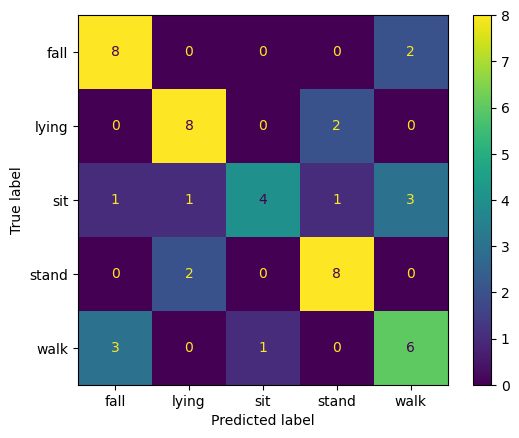

In [65]:
#advanced checks to determine if data leakage is present

def advanced_leakage_checks(X_train, X_test, y_train, y_test, df):
    #Feature Distribution Comparison
    from scipy import stats
    print("\nFeature Distribution Comparison (Train vs Test):")
    for i in range(X_train.shape[1]):
        train_feat = X_train[:,i]
        test_feat = X_test[:,i]
        ks_stat, p_value = stats.ks_2samp(train_feat, test_feat)
        print(f"Feature {i}: KS stat={ks_stat:.3f}, p-value={p_value:.3f}")

def model_sanity_checks(model, X_train, X_test, y_train, y_test):
    #Shuffled Labels Test
    shuffled_scores = []
    for _ in range(5):
        y_shuffled = np.random.permutation(y_train)
        model.fit(X_train, y_shuffled)
        shuffled_scores.append(model.score(X_test, y_test))
    print(f"\nShuffled labels test scores: {np.mean(shuffled_scores):.3f}±{np.std(shuffled_scores):.3f}")

    #Noise Sensitivity Test
    X_test_noisy = X_test + np.random.normal(0, 0.1*X_test.std(), X_test.shape)
    noisy_score = model.score(X_test_noisy, y_test)
    print(f"Noise sensitivity test: {noisy_score:.3f} vs original {model.score(X_test, y_test):.3f}")

    #Feature Importance Analysis
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        print("\nTop 3 Features:")
        for i in np.argsort(importances)[-3:][::-1]:
            print(f"Feature {i}: importance={importances[i]:.3f}")

if __name__ == "__main__":
    print("=== COMPREHENSIVE MODEL DIAGNOSTICS ===")
    
    #load data
    df = enhanced_data_loading(DATA_DIR)
    X = np.stack(df['features'].values)
    y = df['encoded_label'].values
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)
    
    model = RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE)
    model.fit(X_train, y_train)
    
    print("\n[1] PERFORMANCE ANALYSIS")
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred, target_names=le.classes_))
    
    print("\n[2] LEAKAGE CHECKS")
    advanced_leakage_checks(X_train, X_test, y_train, y_test, df)
    
    print("\n[3] MODEL SANITY CHECKS")
    model_sanity_checks(model, X_train, X_test, y_train, y_test)
    
    print("\n[4] CONFUSION MATRIX")
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=le.classes_)
    plt.show()